In [156]:
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [157]:
region_city={'NSW1':'sydney','QLD1':'brisbane','SA1':'adelaide','VIC1':'melbourne'}
regions = ['NSW1', 'QLD1', 'SA1', 'VIC1']
cities = ['sydney', 'brisbane', 'adelaide', 'melbourne']

In [158]:
# List all datasets and accompanying files

DATA_PATH = "/course/data/a2/weather"
filelist = []
for file in os.listdir(DATA_PATH):
    if file.endswith(".csv"):
        filelist.append(os.path.join(DATA_PATH, file))
filelist.remove('/course/data/a2/weather/price_demand_data.csv')

# Cleaning data

In [159]:
# variable for storing data
data = {}
           
for f in filelist:
    region = f.split('.')[0].split('/')[-1].split('_')[1]
    df = pd.read_csv(f)

    print('\n########################################################################################################\n')
    print(region, '\n')
    print(df.info(),'\n')

    # Convert date to datetime datatype
    df['Date'] = pd.to_datetime(df['Date'])

    # Replace Calm with 0
    df = df.replace('Calm', 0)

    # Convert windspeed datatype to float
    df = df.astype({df.columns[13]:float, df.columns[19]:float})

    # Remove columns with a lot of null values
    df = df.dropna(axis=1, thresh = 350)

    # Remove all NAN values from object datatype as we can't fill anything in them
    object_columns = df.select_dtypes(include=['object']).columns
    df = df.dropna(subset = object_columns)

    # Replace other null values with mean
    df = df.fillna(df.mean())
    print('\n******Cleaned data:*******\n')
    print(df.info(),'\n')
    data[region] = df


########################################################################################################

adelaide 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               424 non-null    object 
 1   Minimum temperature (°C)           424 non-null    float64
 2   Maximum temperature (°C)           422 non-null    float64
 3   Rainfall (mm)                      417 non-null    float64
 4   Evaporation (mm)                   0 non-null      float64
 5   Sunshine (hours)                   0 non-null      float64
 6   Direction of maximum wind gust     416 non-null    object 
 7   Speed of maximum wind gust (km/h)  416 non-null    float64
 8   Time of maximum wind gust          416 non-null    object 
 9   9am Temperature (°C)               424 non-null    float64
 10  9am 

/tmp/ipykernel_34/3362432188.py:29: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df = df.fillna(df.mean())
/tmp/ipykernel_34/3362432188.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())
/tmp/ipykernel_34/3362432188.py:29: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df = df.fillna(df.mean())
/tmp/ipykernel_34/3362432188.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df = df.fillna(df.mean())
/tmp/ipykernel_34/3362432188

## Price demand data

In [160]:
df = pd.read_csv('/course/data/a2/weather/price_demand_data.csv')
df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])

#getting a date column
df['Date'] = pd.to_datetime(df['SETTLEMENTDATE']).dt.date   
df['Date'] = pd.to_datetime(df['Date'])

#getting a time column
df['TIME'] = pd.to_datetime(df['SETTLEMENTDATE']).dt.time  

#converting boolean to int
df['PRICESURGE'] = df['PRICESURGE'].astype(int)     
df.info()

data['price_data'] = df
 
# divide the data by region
g = df.groupby('REGION')
for region, index in g.groups.items():
    df_regional = df.iloc[index,:]
    data[region] = df_regional
    
    #Aggregating data based on date
    data[region+'agg'] = df_regional.groupby('Date', as_index = False).agg('mean') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   REGION          240000 non-null  object        
 1   SETTLEMENTDATE  240000 non-null  datetime64[ns]
 2   TOTALDEMAND     240000 non-null  float64       
 3   PRICESURGE      240000 non-null  int64         
 4   Date            240000 non-null  datetime64[ns]
 5   TIME            240000 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 11.0+ MB


## Getting 9 am and 3 pm data

In [161]:
#Separating columns that contain values at 3pm and 9am
threepmcols=data['sydney'].columns[[0,15,16,18,19,20]]
nineamcols=data['sydney'].columns[[0,9,10,12,13,14]]

In [162]:
for region, city in region_city.items():
    
    # 3pm data
    df1 = data[region][data[region]['TIME'] == datetime.datetime.strptime('15:00:00','%H:%M:%S').time()]
    df1 = df1[['Date','TOTALDEMAND','PRICESURGE']]
    df2 = data[city][threepmcols]
    dfmerged = pd.merge(df2, df1, how='inner', left_on='Date', right_on = 'Date')
    data[city+'3pm'] = dfmerged

    # 9am data
    df1 = data[region][data[region]['TIME'] == datetime.datetime.strptime('09:00:00','%H:%M:%S').time()]
    df1 = df1[['Date','TOTALDEMAND','PRICESURGE']]
    df2 = data[city][nineamcols]
    dfmerged = pd.merge(df2, df1, how='inner', left_on='Date', right_on = 'Date')
    data[city+'9am'] = dfmerged
    

## Joining the datasets

NSW1 - Sydney <br>
QLD1 - Brisbane <br>
SA1 - Adelaide <br>
VIC1 - Melbourne

In [163]:
for region, city in region_city.items():
    dfleft = data[city]
    dfright = data[region+'agg']
    dfmerged = pd.merge(dfleft, dfright, how='inner', left_on='Date', right_on = 'Date')
    pricesurgebool = dfmerged['PRICESURGE'].copy()
    pricesurgebool[pricesurgebool!=0] = 1
    dfmerged['PRICESURGEBOOL'] = pricesurgebool
    data[city] = dfmerged

## Getting data distribution

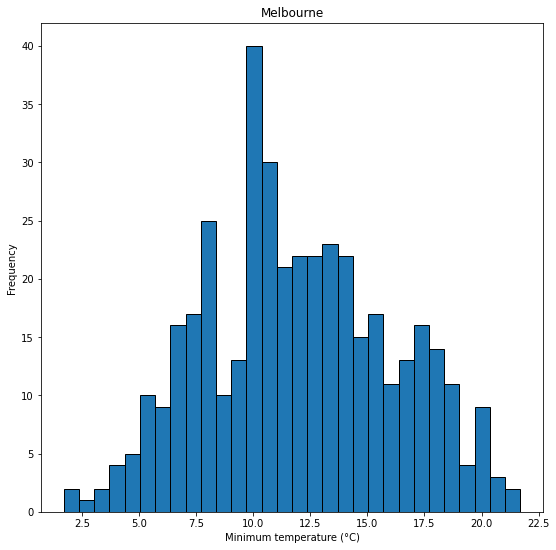

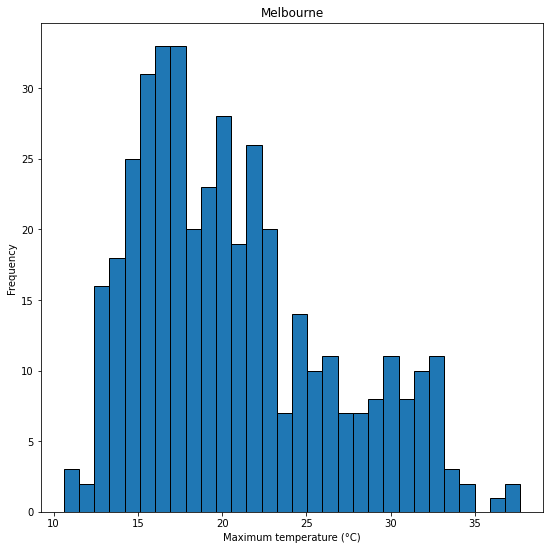

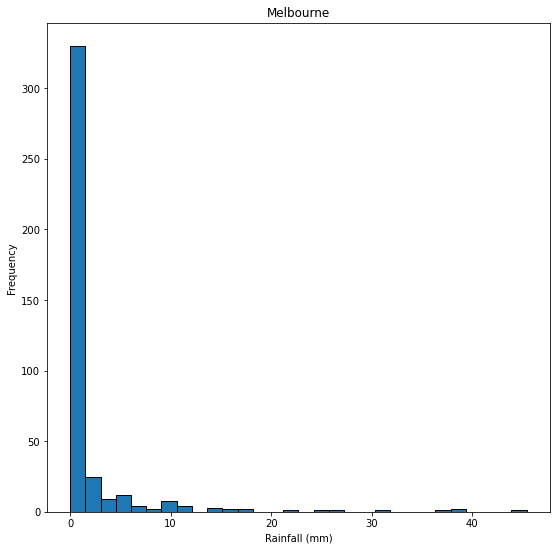

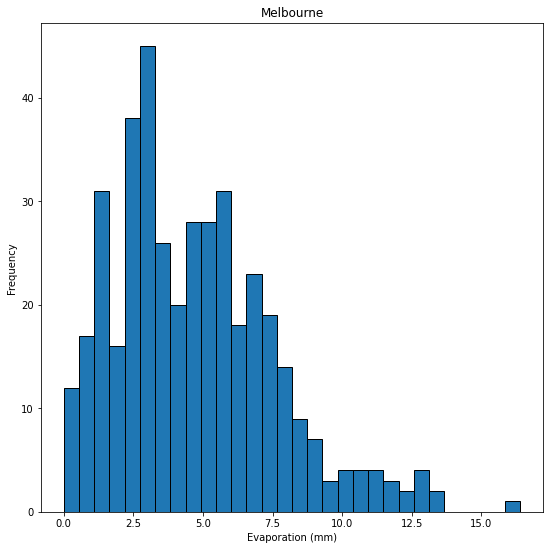

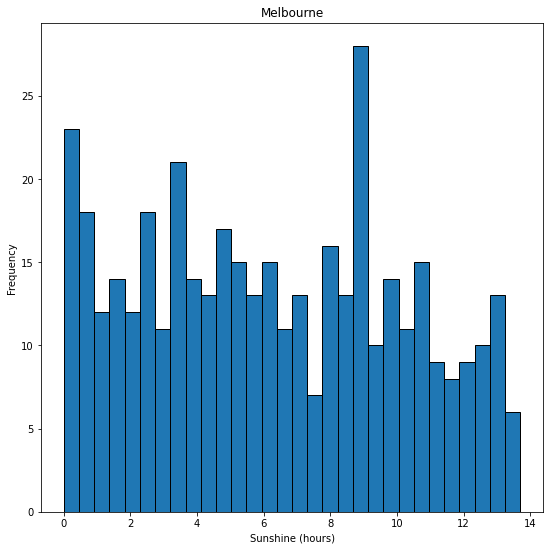

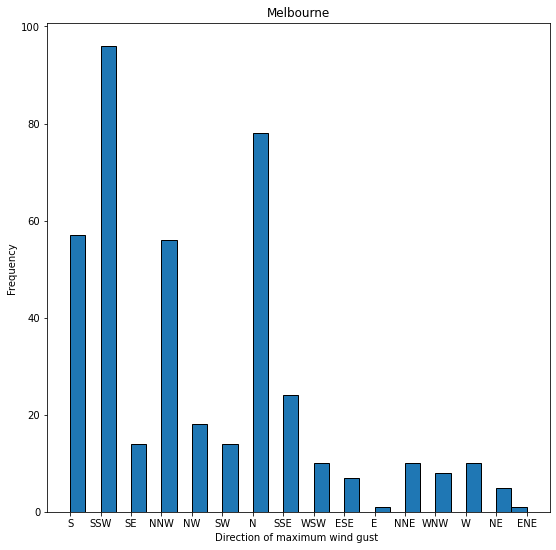

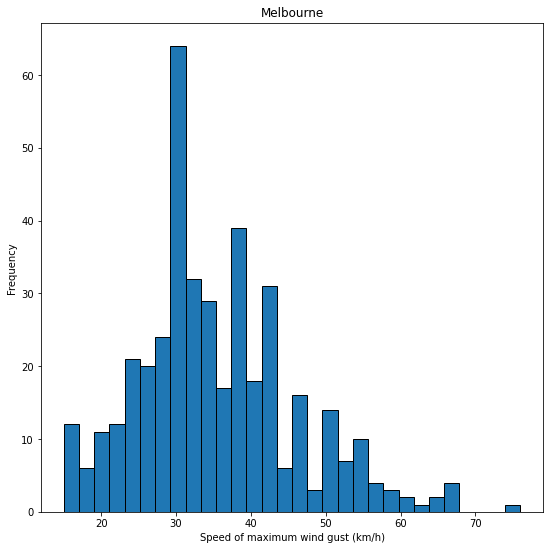

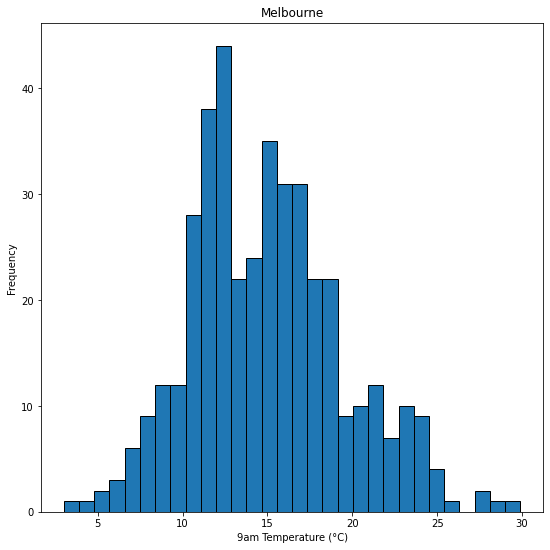

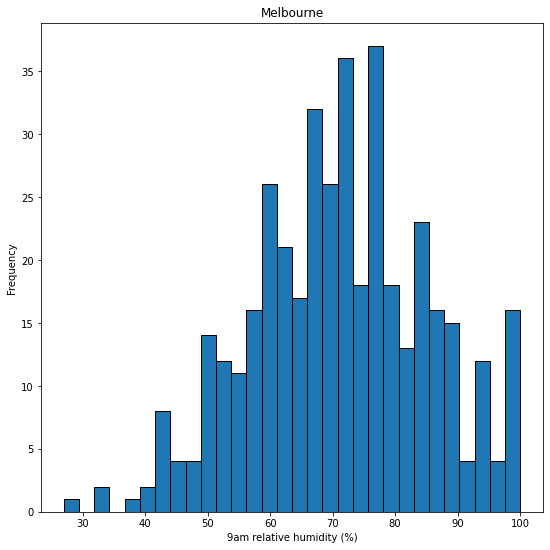

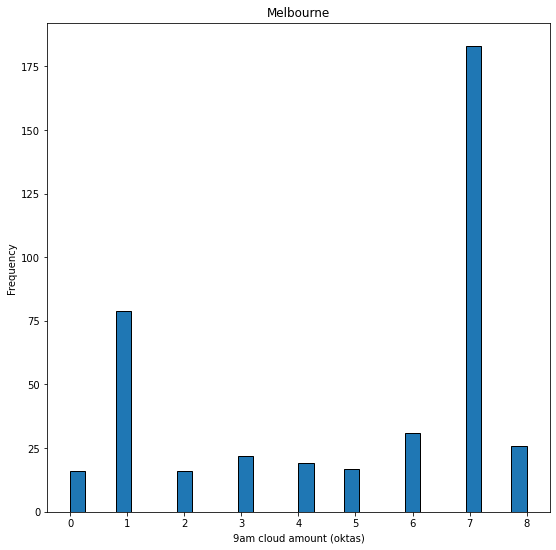

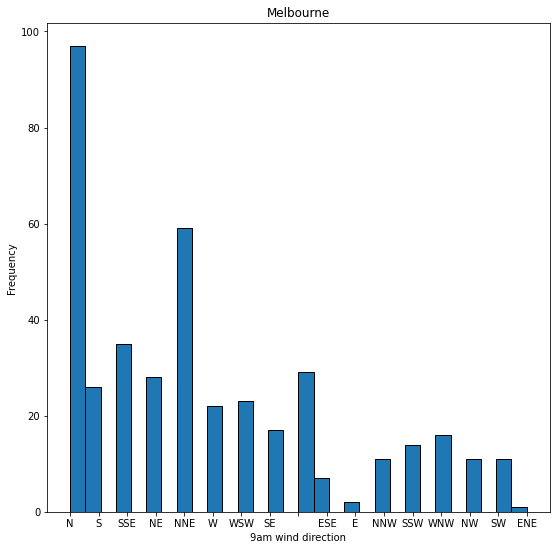

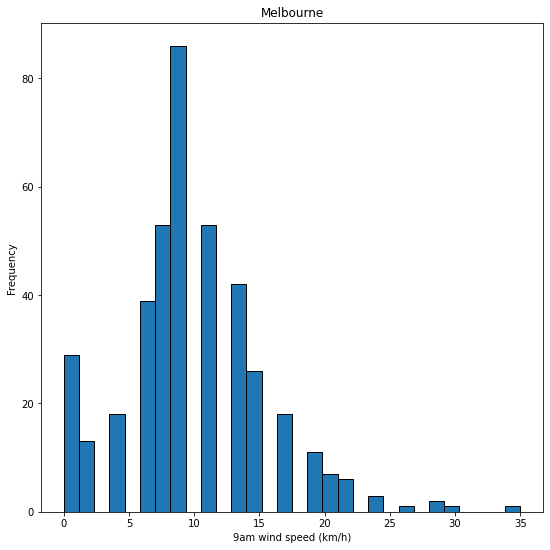

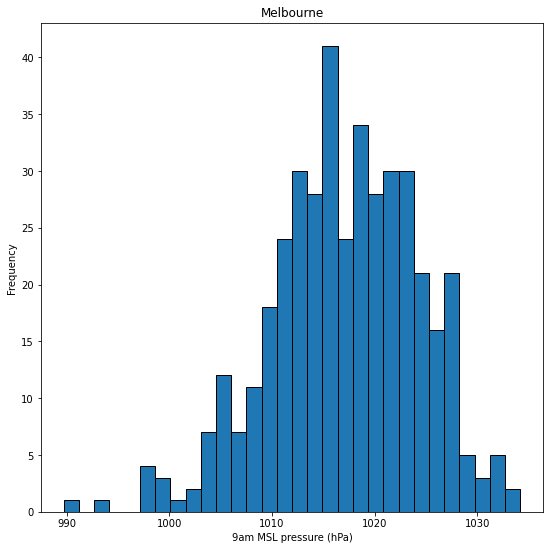

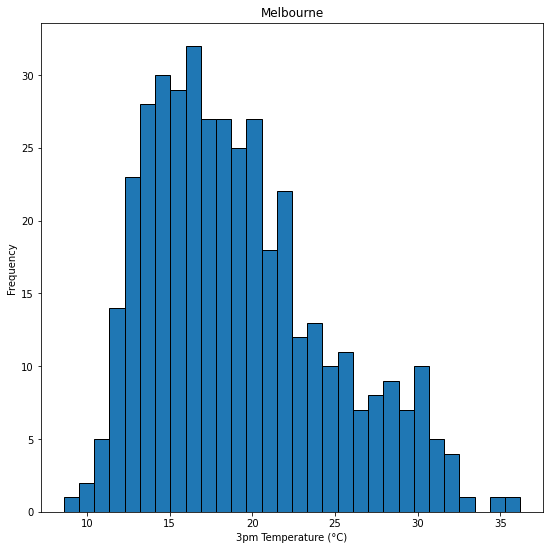

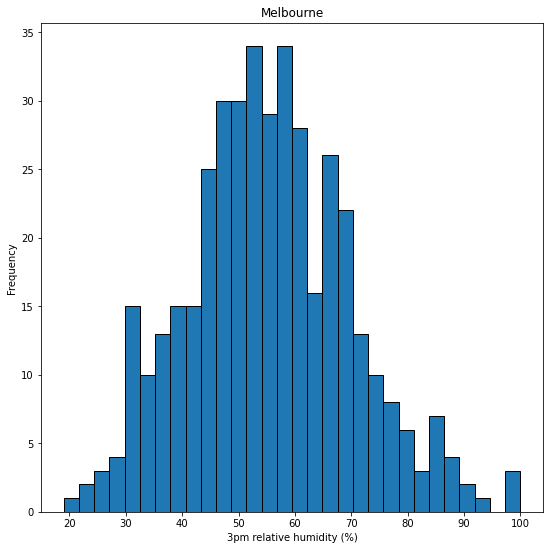

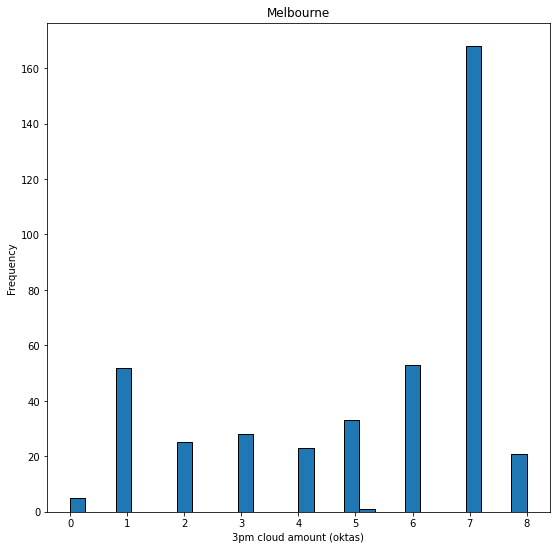

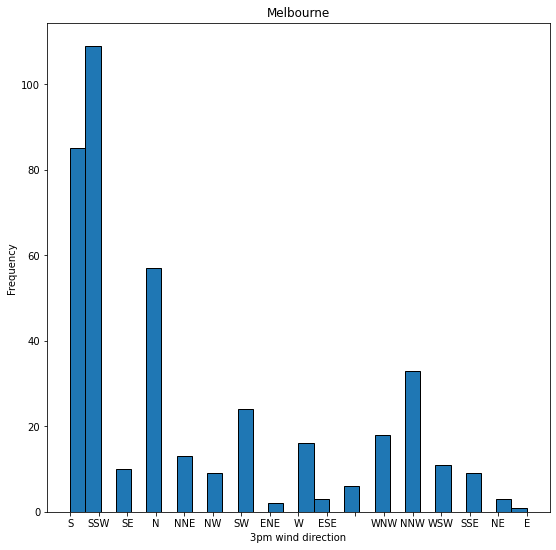

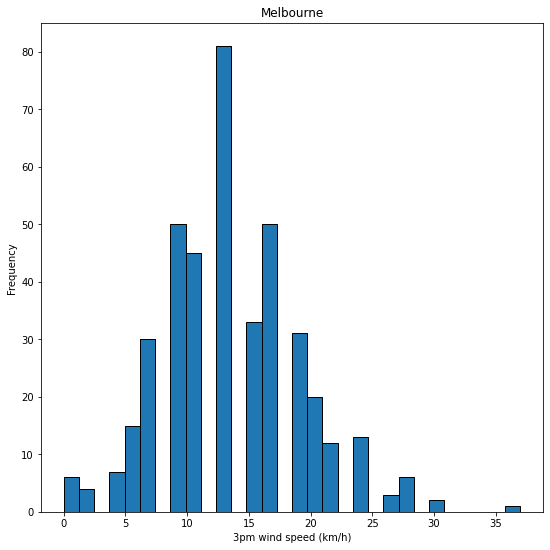

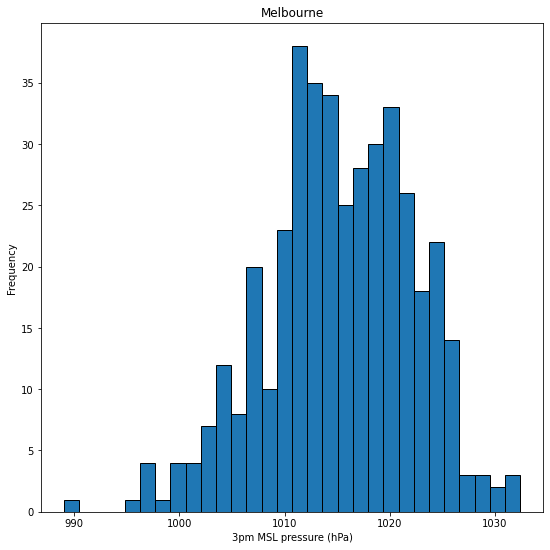

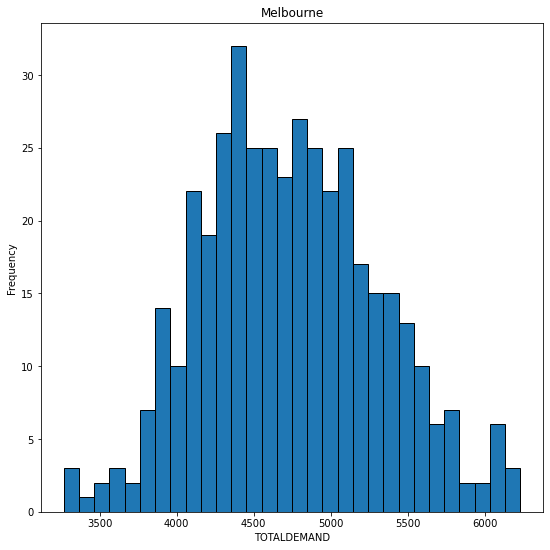

In [164]:
for col in data['sydney']:
    #We don't want these columns as they don't illustrate the link between weather parameter and energy demand.
    if col == 'Date' or col == 'Time of maximum wind gust' or col =='PRICESURGE' or col =='PRICESURGEBOOL':
        continue
    plt.figure(figsize=(9,9))
    plt.title(city.capitalize())
    plt.hist(data[city][col], bins=30,ec='black')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


## Getting Correlation Matrices for each city

In [165]:
df = data['sydney']
df = df[df.columns[0:-2]]
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_34/3596567500.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


In [166]:
df = data['melbourne']
df = df[df.columns[0:-2]]
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_34/3574076554.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


In [167]:
df = data['adelaide']
df = df[df.columns[0:-2]]
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_34/324151900.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


In [168]:
df = data['brisbane']
df = df[df.columns[0:-2]]
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_34/3228715199.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


# Plotting

### Time series of energy demand data

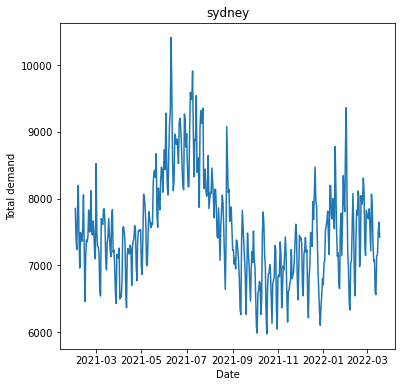

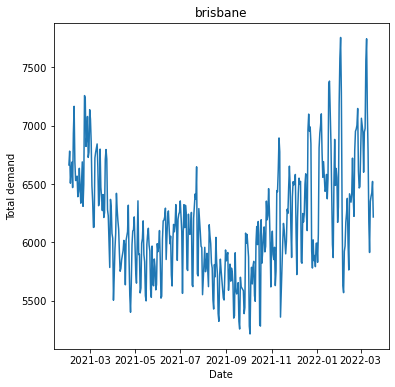

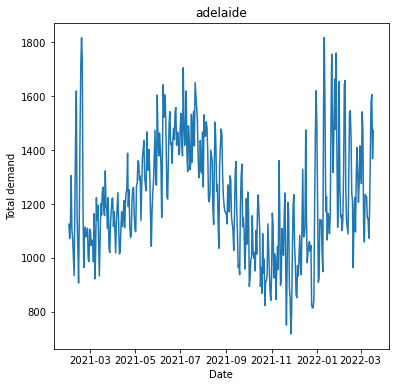

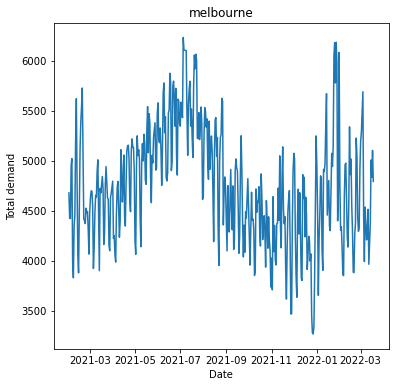

In [169]:
for city in cities:
    df = data[city]
    x = df['Date']
    y = df['TOTALDEMAND']
    z = df['PRICESURGE']
    plt.figure(figsize=(6,6))
    plt.title(city)
    plt.ylabel('Total demand')
    plt.xlabel('Date')
    plt.plot(x,y)
    plt.show()

### 9 am plots

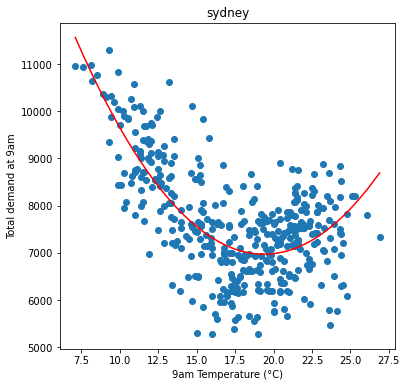

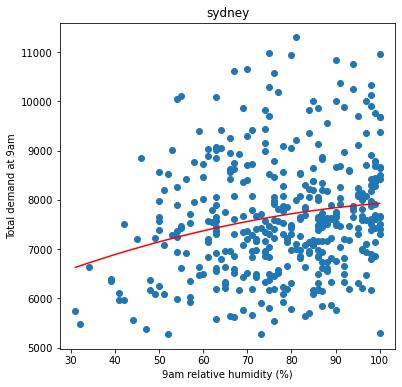

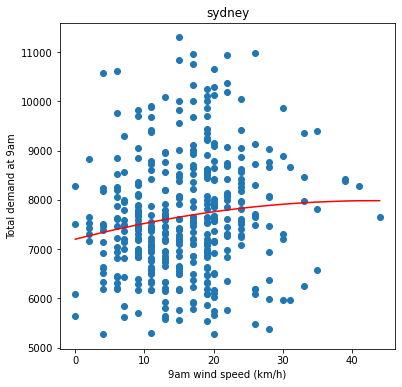

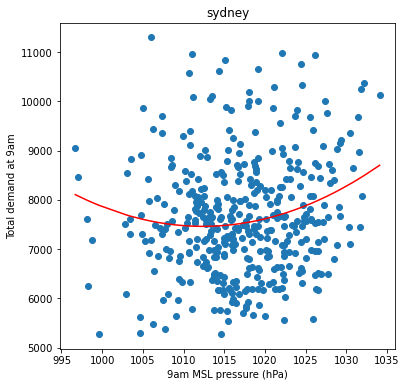

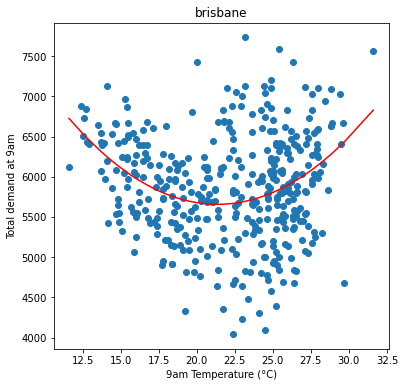

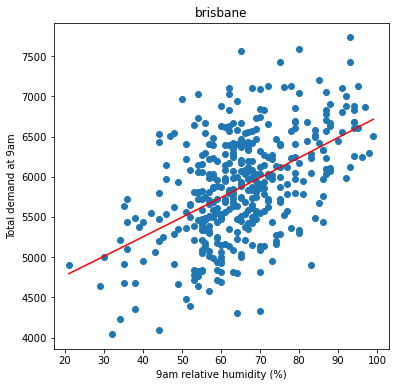

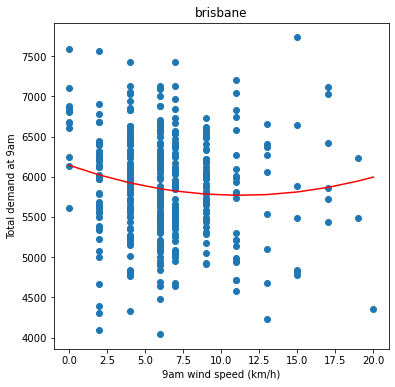

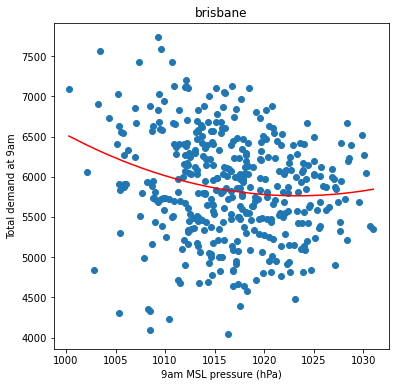

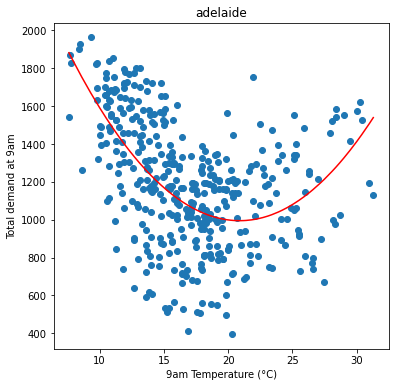

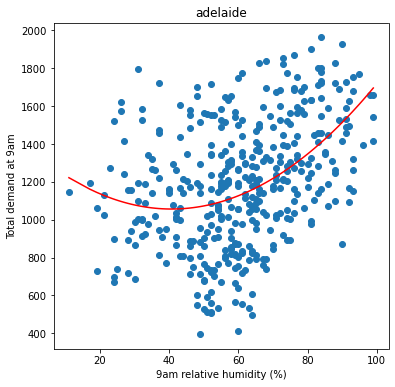

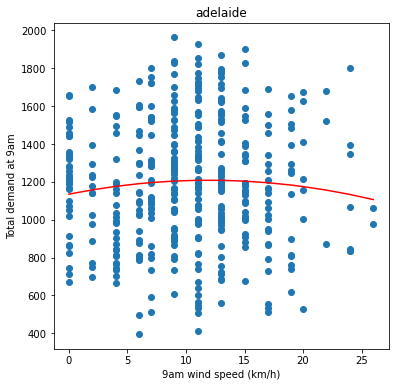

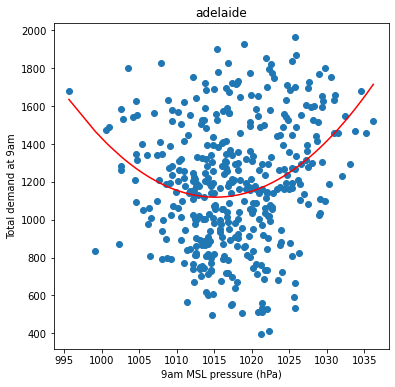

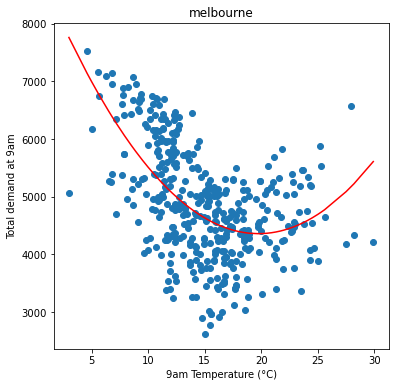

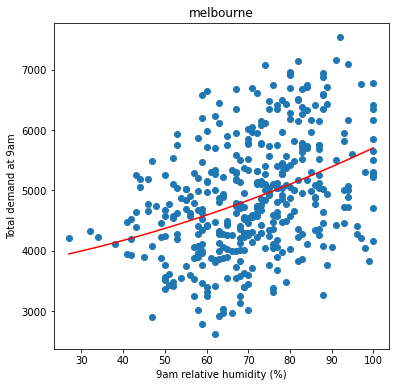

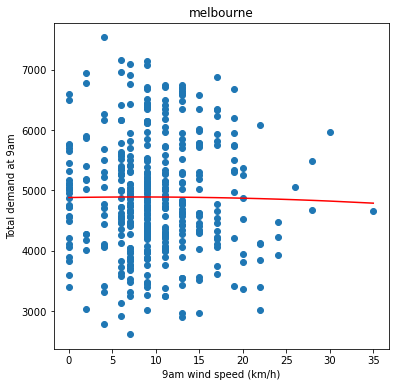

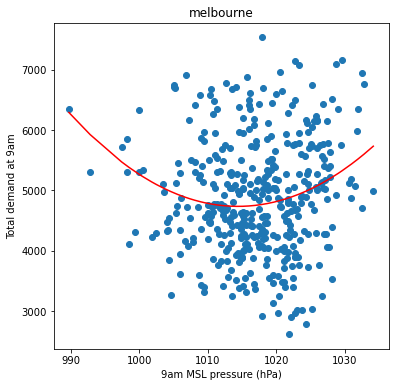

In [170]:
for city in cities:
    df1 = data[city+'9am']
    y=df1['TOTALDEMAND']
    for col in df1.columns[:-2]:
        if df1[col].dtype == 'float64' or df1[col].dtype == 'int64':
            x = df1[col].values
            plt.figure(figsize=(6,6))
            plt.ylabel('Total demand at 9am')
            plt.title(city)
            plt.xlabel(col)
            p = np.polyfit(x, y, 2)
            fit = np.poly1d(p)
            y_fit = fit(np.unique(x))
            plt.plot(np.unique(x),y_fit, color='red')
            plt.scatter(x,y)
            plt.show()


### 3pm plots

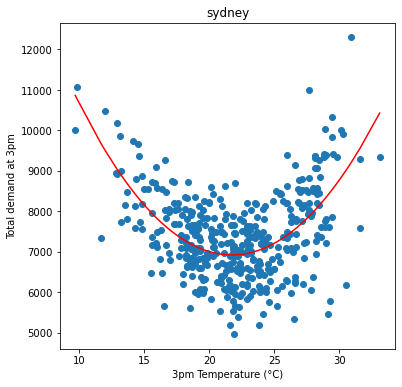

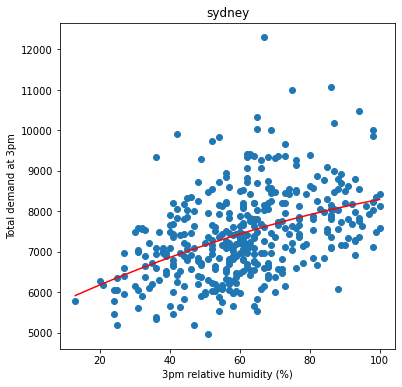

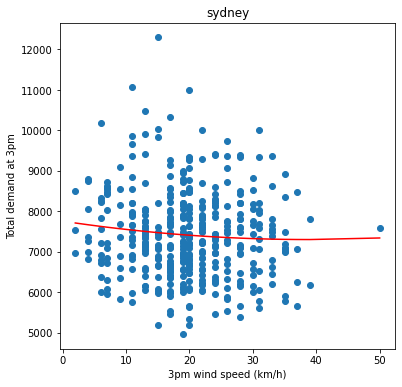

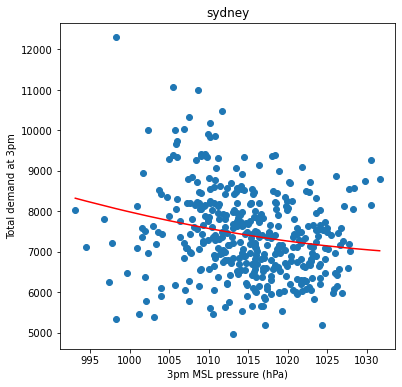

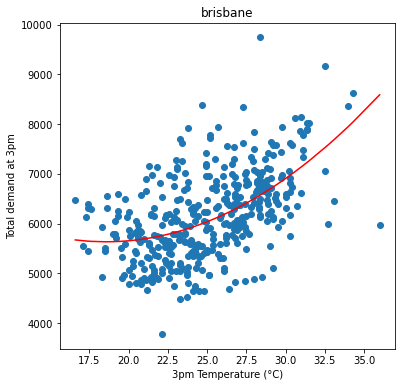

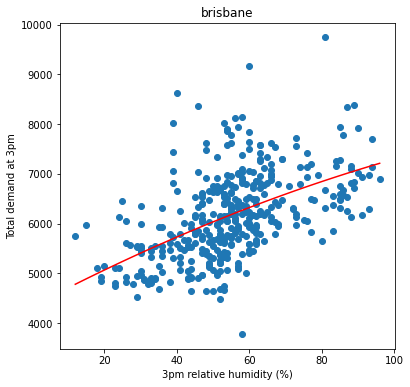

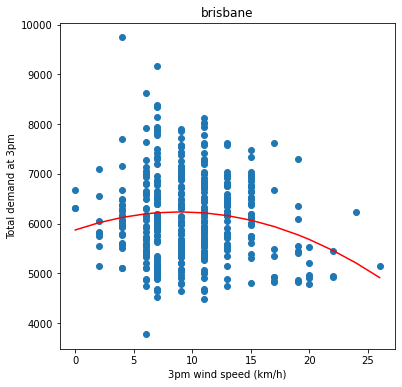

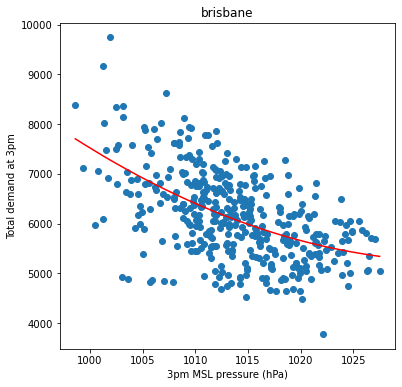

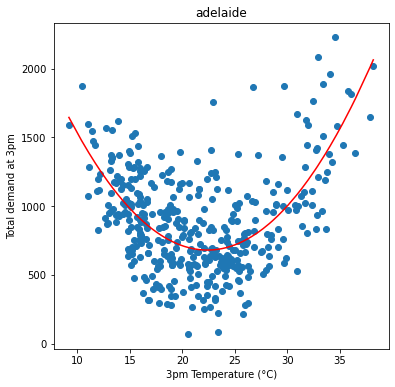

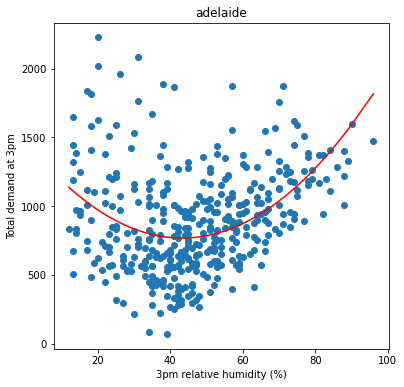

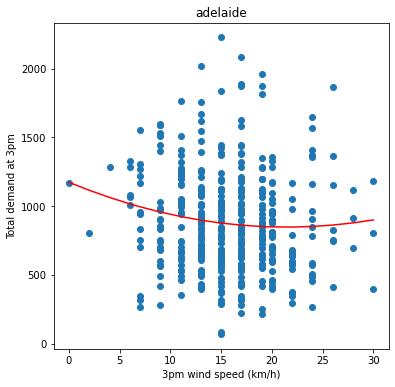

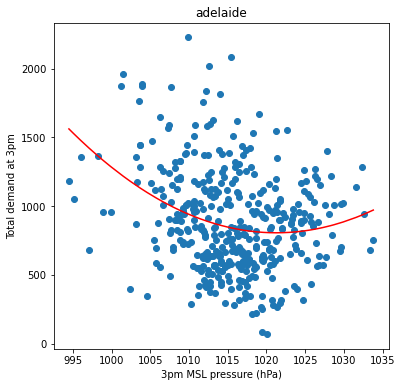

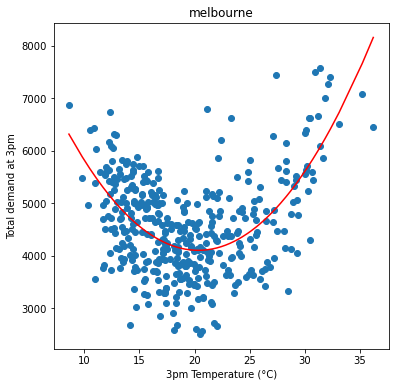

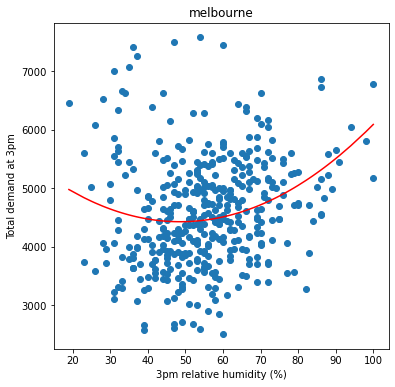

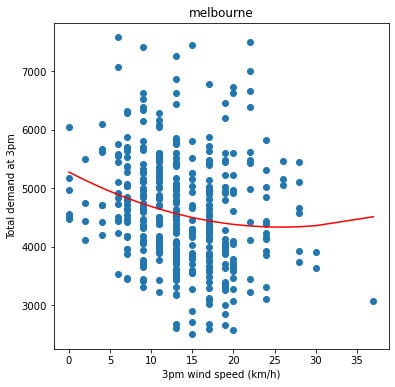

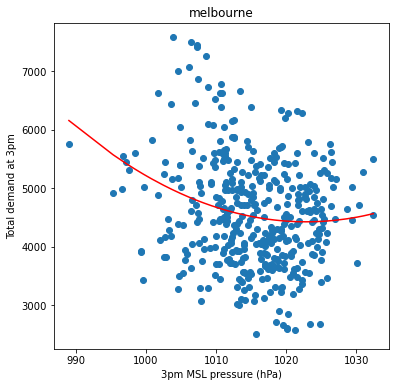

In [171]:
for city in cities:
    df1 = data[city+'3pm']
    y=df1['TOTALDEMAND']
    for col in df1.columns[:-2]:
        if df1[col].dtype == 'float64' or df1[col].dtype == 'int64':
            x = df1[col].values
            plt.figure(figsize=(6,6))
            plt.ylabel('Total demand at 3pm')
            plt.title(city)
            plt.xlabel(col)
            p = np.polyfit(x, y, 2)
            fit = np.poly1d(p)
            y_fit = fit(np.unique(x))
            plt.plot(np.unique(x),y_fit, color='red')
            plt.scatter(x,y)
            plt.show()

# Multiple Linear Regression

In [172]:
# function for splitting data into train-test and rescaling them.

def spittling_scaling(df):

    # splitting the dataset
    df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 0)

    # getting all the values that are not dummny variables
    num_vars = []
    for col in df.columns:
        
        if df[col].dtype!='uint8' and col!='TOTALDEMAND':
            num_vars.append(col)

    y_train = df_train.pop('TOTALDEMAND')
    X_train = df_train

    y_test = df_test.pop('TOTALDEMAND')
    X_test = df_test

    # Applying scaler() to all the columns except the dummy variables
    scaler_x = StandardScaler()
    scl_x = scaler_x.fit(X_train[num_vars]) 
    X_train[num_vars] = scl_x.transform(X_train[num_vars]) #  scaling training x
    X_test[num_vars] = scl_x.transform(X_test[num_vars])   # scaling test x

    scaler_y = StandardScaler()
    y_train = y_train.values.reshape(-1,1)
    scl_y = scaler_y.fit(y_train)
    y_train = scl_y.transform(y_train)
    y_test = y_test.values.reshape(-1,1)
    y_test = scl_y.transform(y_test)

    return X_train, X_test, y_train, y_test, scl_y

In [173]:
# training the model
def training(X, y_train):
    removed_list = []           # List of insignificant columns that are removed
    
    for i in range(0,64):       # We have 64 parameters
        
        X_train_lm = sm.add_constant(X) 
        lr = sm.OLS(y_train, X_train_lm).fit()

        # Creating a dataframe of p-values and parameters
        d = {}
        for i in X.columns.tolist():
            d[f'{i}'] = lr.pvalues[i]
        df_pvalues= pd.DataFrame(d.items(), columns=['Var_name', 'p-Value'])

        # Creating High vif value dataframe
        vif = pd.DataFrame()
        vif['Features'] = X.columns
        vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif['VIF'] = round(vif['VIF'], 2)
        vif = vif.sort_values(by = "VIF", ascending = False)
        highvif = vif[vif['VIF']>6]['Features']

        # if there are still parameters with high VIF, remove the one with highest p-value
        if len(highvif)!=0:
            df_highvif = df_pvalues[df_pvalues['Var_name'].isin(highvif)]
            maxpvalue = df_highvif['p-Value'].idxmax()
            removefeature = df_pvalues['Var_name'][maxpvalue]
            X = X.drop(removefeature, 1)
            removed_list.append(removefeature)
        
        # if no high VIF variable left remove the ones with p-values>0.05
        else:
            if max(df_pvalues['p-Value']) > 0.05:
                maxpvalue = df_pvalues['p-Value'].idxmax()
                removefeature = df_pvalues['Var_name'][maxpvalue]
                X = X.drop(removefeature, 1)
                removed_list.append(removefeature)
                
            elif max(df_pvalues['p-Value']) <= 0.05:
                print('Breaking out!!!!')
                break
    
    return lr, removed_list

In [174]:
# Analysing Model
def model_analysis(lr, X_test, y_test, X_train, y_train, removed_list, city, plot=True):

    X_test_m4 = sm.add_constant(X_test)
    X_test_m4 = X_test_m4.drop(removed_list, axis = 1) # Remove insignificant columns

    print(lr.params)

    y_test = scl_y.inverse_transform(y_test)
    y_test = np.squeeze(y_test)
    
    y_pred_test = lr.predict(X_test_m4).values  # Predict the test values
    y_pred_test = y_pred_test.reshape(-1,1)
    y_pred_test = scl_y.inverse_transform(y_pred_test)
    y_pred_test = np.squeeze(y_pred_test)
    r2score_test = r2_score(y_true = y_test, y_pred = y_pred_test) # Calculate R^2 values
   

    X_train_m4 = sm.add_constant(X_train)
    X_train_m4 = X_train_m4.drop(removed_list, axis = 1) # Remove insignificant columns
    
    y_train = scl_y.inverse_transform(y_train)
    y_train = np.squeeze(y_train)
    y_pred_train = lr.predict(X_train_m4).values # Predict the test values
    y_pred_train = y_pred_train.reshape(-1,1)
    y_pred_train = scl_y.inverse_transform(y_pred_train)
    y_pred_train = np.squeeze(y_pred_train)
    r2score_train = r2_score(y_true = y_train, y_pred = y_pred_train) # Calculate R^2 values

    # Calculate errors values
    error_test = y_test - y_pred_test
    error_train = y_train - y_pred_train

    # Get plots if needed, set plot to True
    if plot:
        plt.figure(figsize=(6,6))
        plt.scatter(y_pred_test, y_test)
        plt.plot(np.unique(y_pred_test), np.poly1d(np.polyfit(y_pred_test, y_test, 1))(np.unique(y_pred_test)), color='red')
        plt.xlabel('prediction')
        plt.ylabel('True value')
        plt.title(f'Test({city})')
        plt.show()
        
        plt.figure(figsize=(6,6))
        plt.scatter(y_pred_train, y_train)
        plt.plot(np.unique(y_pred_train), np.poly1d(np.polyfit(y_pred_train, y_train, 1))(np.unique(y_pred_train)), color='red')
        plt.xlabel('prediction')
        plt.ylabel('True value')
        plt.title(f'Train({city})')
        plt.show()


        plt.figure(figsize=(6,6))
        plt.scatter(y_pred_test, error_test)
        plt.plot(y_pred_test,np.zeros(len(y_pred_test)), color='red')
        plt.ylabel('Error')
        plt.xlabel('Prediction')
        plt.title(f'Residual plot Test_value({city})')
        plt.show()

        plt.figure(figsize=(6,6))
        plt.scatter(y_pred_train, error_train)
        plt.plot(y_pred_train, np.zeros(len(y_pred_train)), color='red')
        plt.ylabel('Error')
        plt.xlabel('Prediction')
        plt.title(f'Residual plot Train_value({city})')
        plt.show()

        plt.figure(figsize=(6,6))
        plt.hist(error_test, ec='black')
        plt.title(f'Error plot({city})')
        plt.xlabel('Error(ytrue-ypred)')
        plt.show()
    
    # Get the RMSE
    mse_test = np.sqrt(((y_test - y_pred_test)**2).mean(axis=None))
    mean_test = np.mean(y_test)
    mse_test_rel = mse_test/mean_test
    mse_train = np.sqrt(((y_train - y_pred_train)**2).mean(axis=None))
    mean_train = np.mean(y_train)
    mse_train_rel = mse_train/mean_train
    print(f'MSE_test:{mse_test}/{mean_test}')
    print(f'MSE_train:{mse_train}/{mean_train}')
    print(f'mse_test_rel:{mse_test_rel}')
    print(f'mse_train_rel:{mse_train_rel}')
    print('R2 score_test:', r2score_test)
    print('R2 score_train:', r2score_train)

## With all variables

In [175]:
for city in cities:
    
    df = data[city].copy()
    print(f'\n\n############ {city} ############')
    df = df.drop(['Date','Time of maximum wind gust','PRICESURGE','PRICESURGEBOOL'],1) # Drop useless rows
    
    # Onehot encoding
    onehot = pd.get_dummies(df[['Direction of maximum wind gust ','9am wind direction','3pm wind direction']], drop_first = True)
    
    # Adding a squared temperature column
    df['Minimum temperature (°C) squared'] =  df['Minimum temperature (°C)']**2   
    df['Maximum temperature (°C) squared'] =  df['Maximum temperature (°C)']**2
    df['9am Temperature (°C) squared'] =  df['9am Temperature (°C)']**2
    df['3pm Temperature (°C) squared'] =  df['3pm Temperature (°C)']**2

    # Removing a useless column
    if city == 'sydney':
        onehot = onehot.drop(onehot.columns[16],1)
    
    elif city == 'brisbane':
        onehot = onehot.drop(onehot.columns[16],1)

    elif city == 'adelaide':
        onehot = onehot.drop(onehot.columns[[16,33]],1)

    elif city == 'melbourne':
        onehot = onehot.drop(onehot.columns[[16,33]],1)


    df = df.drop(['Direction of maximum wind gust ','9am wind direction','3pm wind direction'],1) # Drop categorical columns
    df = pd.concat([onehot,df], axis = 1)  # Adding the onehot encoding

    # Splitting the model
    X_train, X_test, y_train, y_test, scl_y = spittling_scaling(df)

    X = X_train.copy()
    
    # Training the model
    lr, removed_list = training(X, y_train)

    # Analysing
    model_analysis(lr, X_test, y_test, X_train, y_train, removed_list, city, False) # Set this to True to get plots



############ sydney ############
Breaking out!!!!
const                                  0.046427
Direction of maximum wind gust _ENE   -0.338149
Direction of maximum wind gust _ESE   -0.404851
Direction of maximum wind gust _N      0.961500
Direction of maximum wind gust _NNW    1.176479
Direction of maximum wind gust _SSE   -0.633695
Direction of maximum wind gust _W      0.385769
9am wind direction_NW                 -0.730596
9am wind direction_WNW                -0.267058
3pm wind direction_NW                  1.096399
3pm wind direction_S                  -0.593068
3pm wind direction_W                   0.556798
Maximum temperature (°C)              -0.315363
9am relative humidity (%)              0.354577
dtype: float64
MSE_test:744.206695344968/7561.01557441701
MSE_train:571.8040729224995/7545.900722038898
mse_test_rel:0.09842681687669316
mse_train_rel:0.0757767818562021
R2 score_test: 0.12869325751793603
R2 score_train: 0.4434202884975337


############ brisbane ############

/tmp/ipykernel_34/3471303148.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Date','Time of maximum wind gust','PRICESURGE','PRICESURGEBOOL'],1) # Drop useless rows
/tmp/ipykernel_34/3471303148.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  onehot = onehot.drop(onehot.columns[16],1)
/tmp/ipykernel_34/3471303148.py:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Direction of maximum wind gust ','9am wind direction','3pm wind direction'],1) # Drop categorical columns
/tmp/ipykernel_34/1272676533.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = X.drop(removefeature, 1)
/tmp/ipykernel_34/1272676

# Using sklearn

In [176]:
# Training the model

def sktrain(X_train, y_train, X_te):
    
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train) # Fitting the model
    y_pred_test = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    return regressor, y_pred_test, y_pred_train 

In [177]:
# Analysing the model
def skanalysis(y_pred_train, y_train, y_pred_test, y_test, X_test, cols, plot=True):
    
    n_test = len(y_test) # number of rows
    n_train = len(y_train)
    p = len(X_test[0]) # number of columns 
    
    error_test = y_test - y_pred_test
    error_train = y_train - y_pred_train
    
    # Getting R^2 and adjusted R^2 scores
    r2score_test = r2_score(y_true = y_test, y_pred = y_pred_test)
    r2score_train = r2_score(y_true = y_train, y_pred = y_pred_train)
    r2scoreadj_test = 1-((1-r2score_test)*(n_test-1)/(n_test-p-1))
    r2scoreadj_train = 1-((1-r2score_train)*(n_train-1)/(n_train-p-1))
    
    # Getting RMSE
    mse_test = np.sqrt(((y_test - y_pred_test)**2).mean(axis=None))
    mean_test = np.mean(y_test)
    mse_test_rel = mse_test/mean_test
    mse_train = np.sqrt(((y_train - y_pred_train)**2).mean(axis=None))
    mean_train = np.mean(y_train)
    mse_train_rel = mse_train/mean_train
    
    print(f'MSE_test:{mse_test}/{mean_test}')
    print(f'MSE_train:{mse_train}/{mean_train}')
    print(f'mse_test_rel:{mse_test_rel}')
    print(f'mse_train_rel:{mse_train_rel}')
    print('R2 score_test:', r2score_test)
    print('R2 score_train:', r2score_train)
    print('R2 score_test adj:', r2scoreadj_test)
    print('R2 score_train adj:', r2scoreadj_train)
    
    # Plotting all data
    if plot:
        # Test prediction
        plt.figure(figsize=(6,6))
        plt.scatter(y_pred_test, y_test)
        plt.plot(np.unique(y_pred_test), np.poly1d(np.polyfit(y_pred_test, y_test, 1))(np.unique(y_pred_test)), color='red')
        plt.xlabel('prediction')
        plt.ylabel('True value')
        plt.title(f'Test({city})')
        plt.show()

        # Train prediction
        plt.figure(figsize=(6,6))
        plt.scatter(y_pred_train, y_train)
        plt.plot(np.unique(y_pred_train), np.poly1d(np.polyfit(y_pred_train, y_train, 1))(np.unique(y_pred_train)), color='red')
        plt.xlabel('prediction')
        plt.ylabel('True value')
        plt.title(f'Train({city})')
        plt.show()

        # Residual of test data
        plt.figure(figsize=(6,6))
        plt.scatter(y_pred_test, error_test)
        plt.plot(y_pred_test, np.zeros(len(y_pred_test)) , color='red')
        plt.ylabel('Error')
        plt.xlabel('Prediction')
        plt.title(f'Residual plot for Test_value({city})')
        plt.show()

        # Residual of train data
        plt.figure(figsize=(6,6))
        plt.scatter(y_pred_train, error_train)
        plt.plot(y_pred_train,np.zeros(len(y_pred_train)), color='red')
        plt.ylabel('Error')
        plt.xlabel('Prediction')
        plt.title(f'Residual plot for Train_value({city})')
        plt.show()

        # Plotting error wrt Independent_values
        for i,col in enumerate(cols):
            plt.figure(figsize=(6,6))
            x = X_test[:,i]
            y = error_test
            plt.scatter(x, y)
            plt.plot(x, np.zeros(len(x)), color='red')
            plt.ylabel('Error')
            plt.xlabel(col)
            plt.title(f'Error v/s Independent_values({city})')
            plt.show()


        # Error histogram
        plt.figure(figsize=(6,6))
        plt.hist(error_test, ec='black')
        plt.title(f'Error plot({city})')
        plt.xlabel('Error(ytrue-ypred)')
        plt.show()

## With all variables except categorical

/tmp/ipykernel_34/2428355245.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Date','Time of maximum wind gust','PRICESURGE','PRICESURGEBOOL'],1)
/tmp/ipykernel_34/2428355245.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Direction of maximum wind gust ','9am wind direction','3pm wind direction'],1)
/tmp/ipykernel_34/2428355245.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Date','Time of maximum wind gust','PRICESURGE','PRICESURGEBOOL'],1)
/tmp/ipykernel_34/2428355245.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop(['Direction of maximum wind gust ','9am wind direct



############ sydney ############

MSE_test:695.8329645804452/7561.01557441701
MSE_train:611.251489852044/7545.900722038898
mse_test_rel:0.09202903468878217
mse_train_rel:0.08100444365333291
R2 score_test: 0.2382825101591407
R2 score_train: 0.36397711314831604
R2 score_test adj: 0.04785313769892585
R2 score_train adj: 0.33082934054366797


############ brisbane ############

MSE_test:376.0196564346268/6137.431941872428
MSE_train:309.4676732375707/6184.993636737219
mse_test_rel:0.06126661118133874
mse_train_rel:0.05003524521018339
R2 score_test: 0.3835417625356211
R2 score_train: 0.5531018990465614
R2 score_test adj: 0.24128216927461055
R2 score_train adj: 0.5310510059074114


############ adelaide ############

MSE_test:198.96062934572686/1225.377881515775
MSE_train:186.22414290325924/1218.8685817935798
mse_test_rel:0.1623667542453234
mse_train_rel:0.15278443113959683
R2 score_test: 0.18731286111600376
R2 score_train: 0.17533971092899492
R2 score_test adj: 0.04389748366588675
R2 score

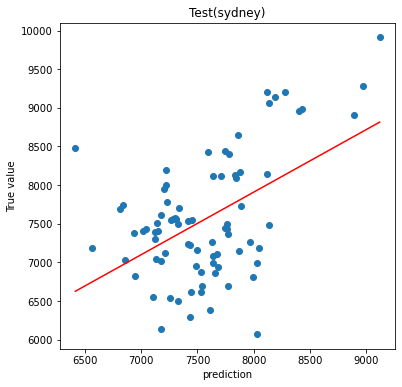

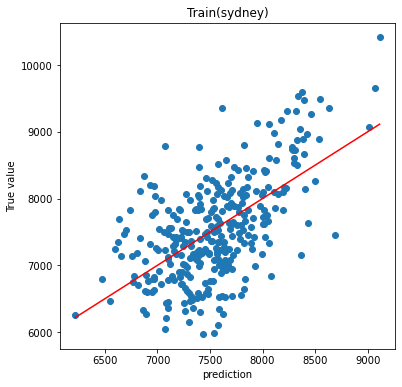

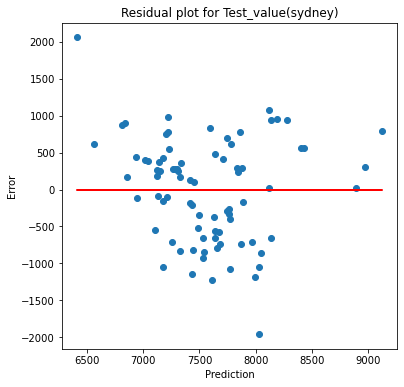

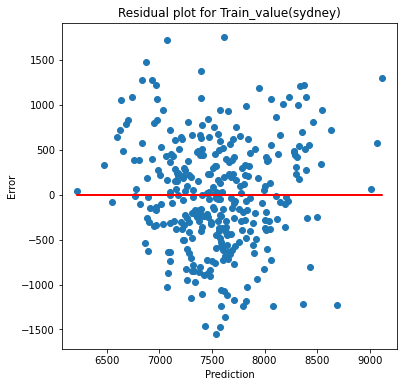

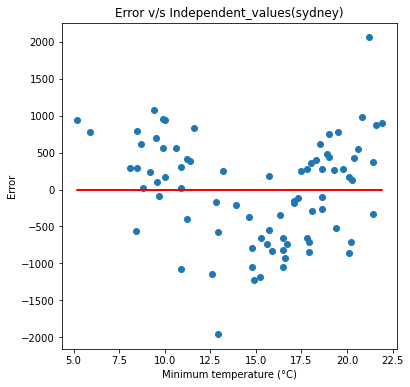

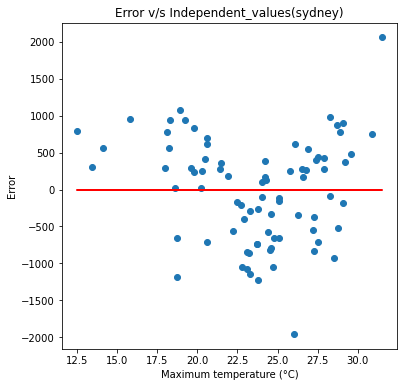

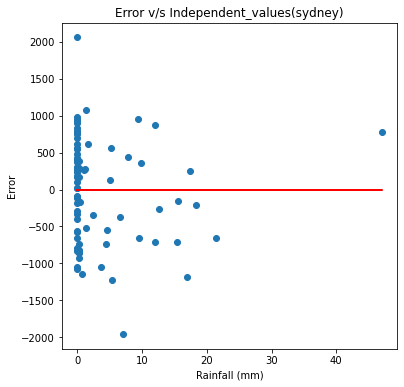

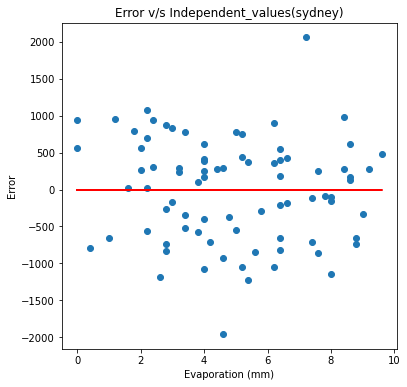

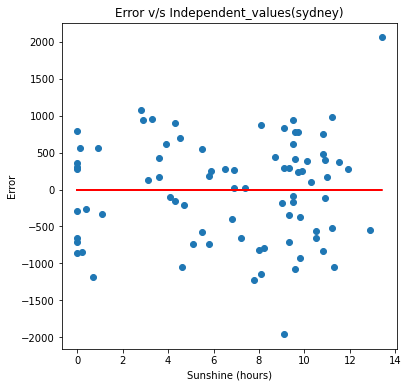

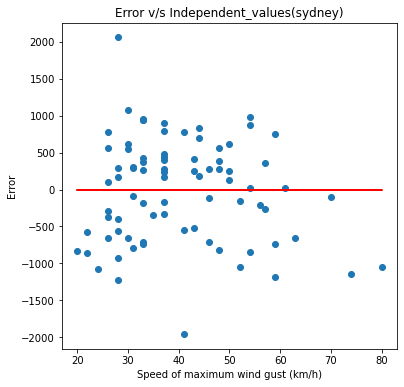

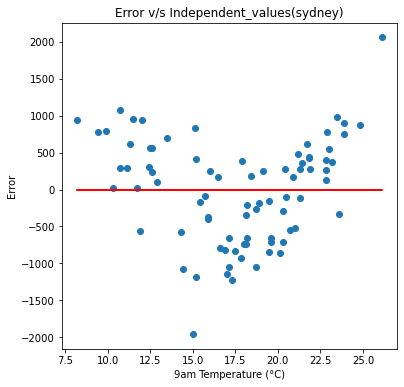

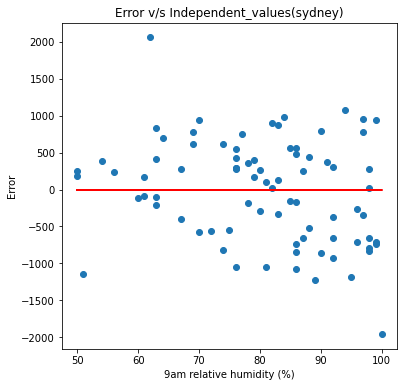

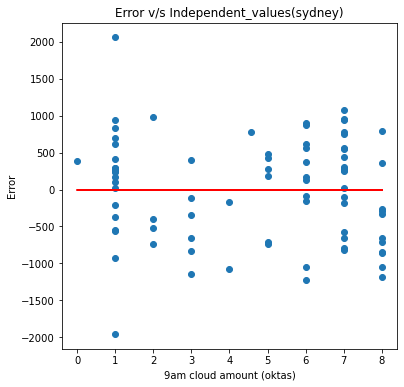

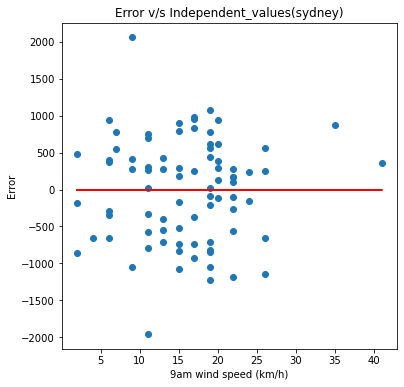

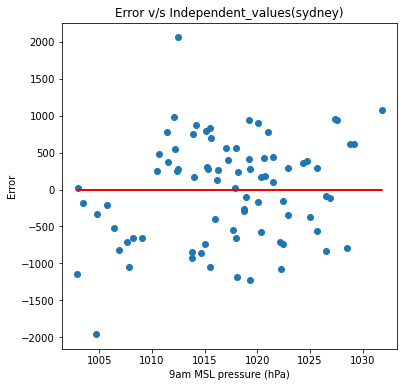

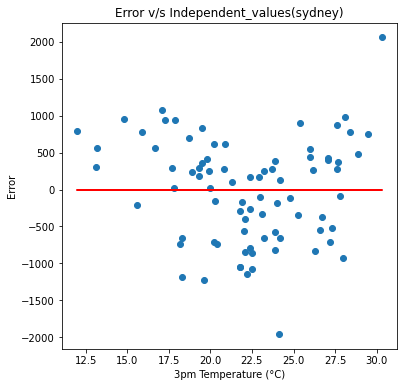

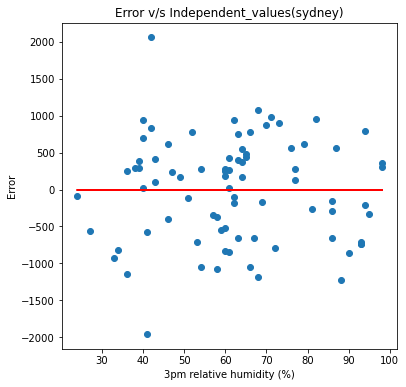

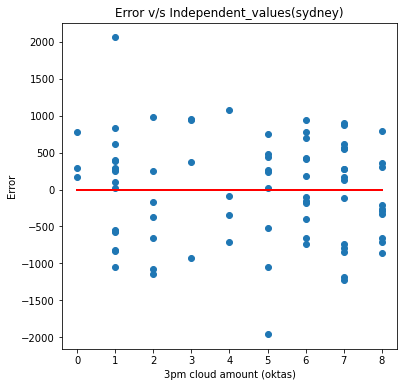

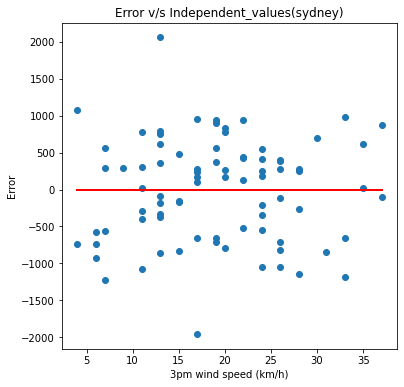

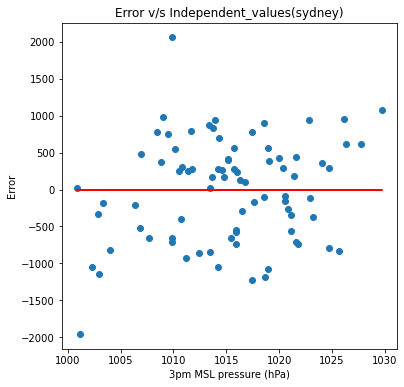

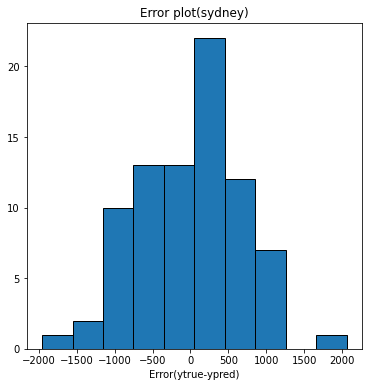

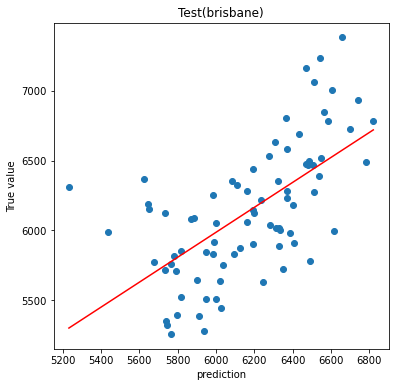

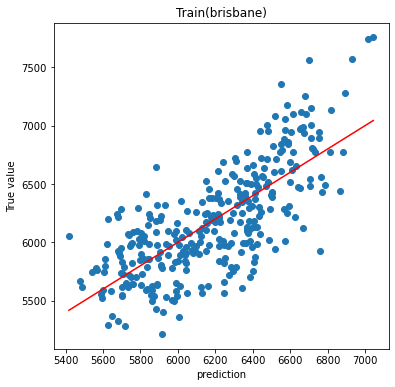

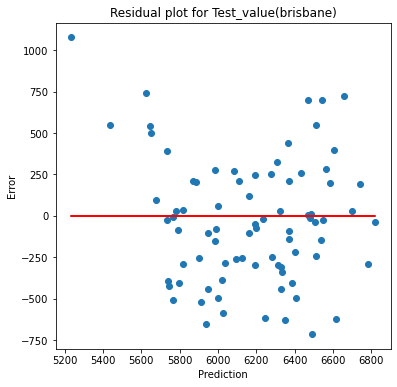

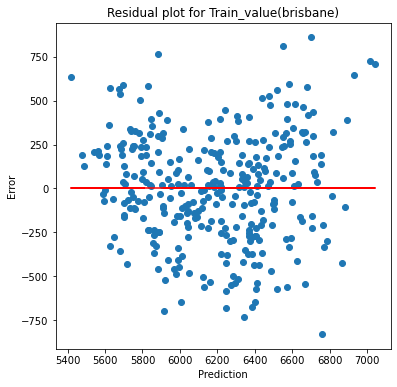

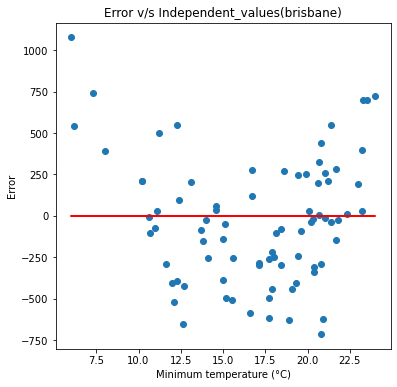

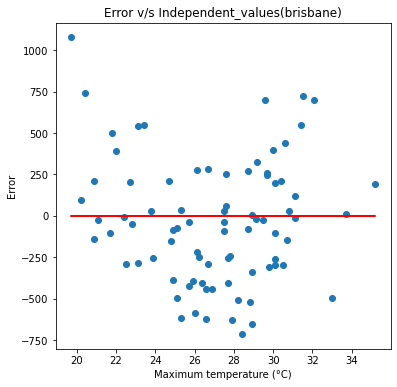

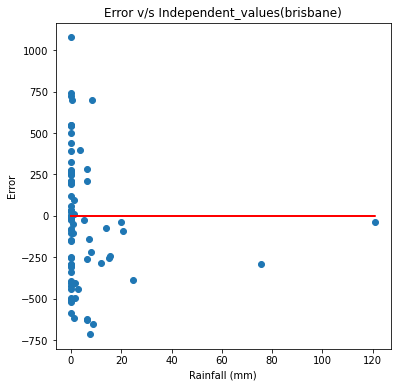

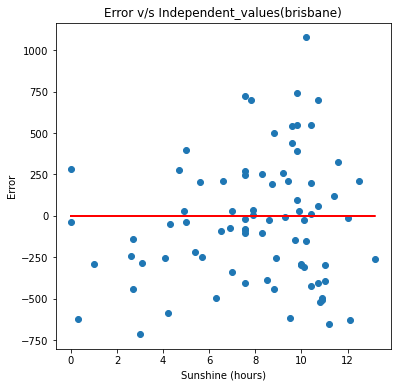

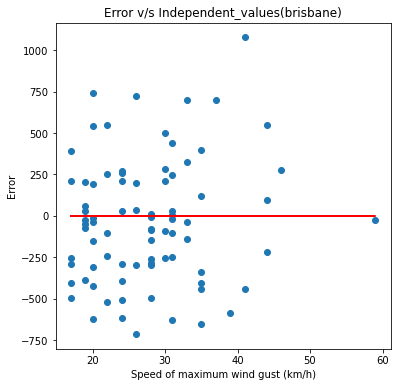

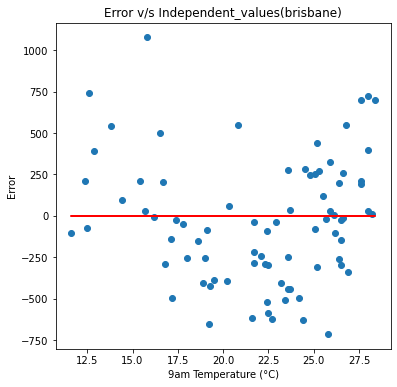

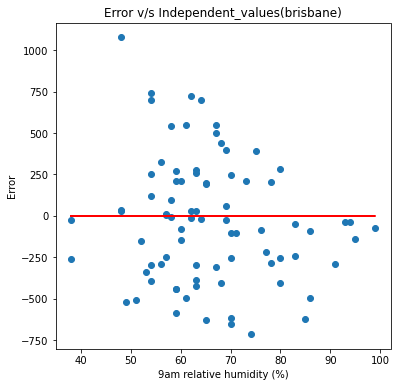

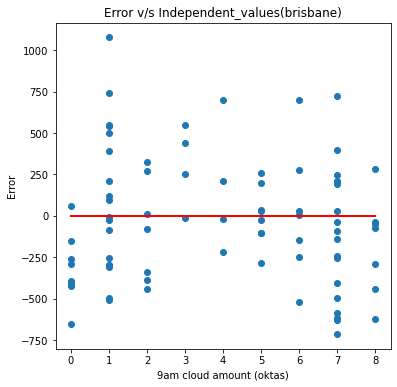

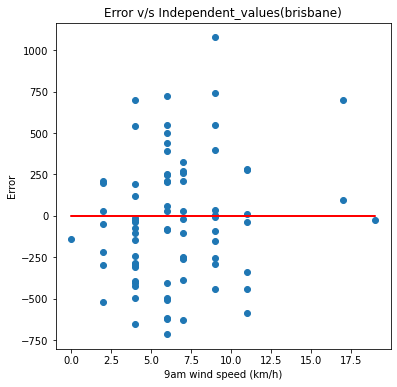

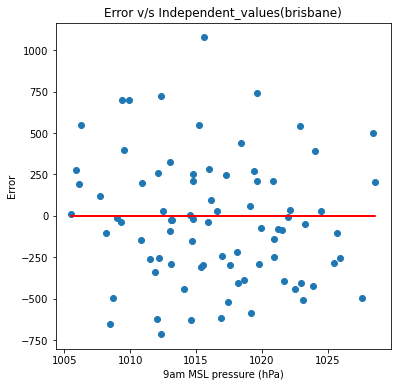

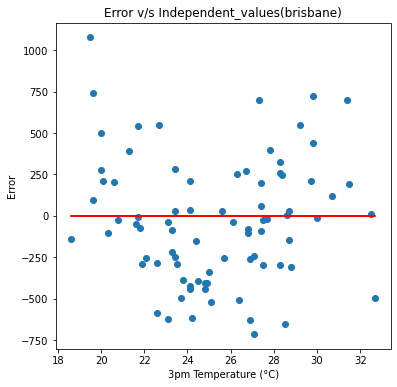

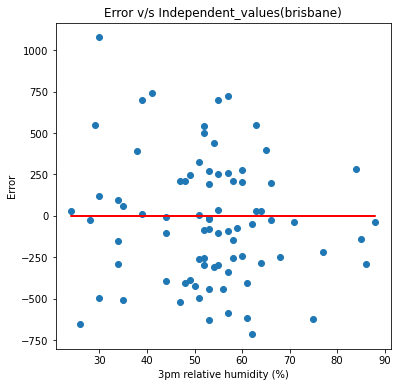

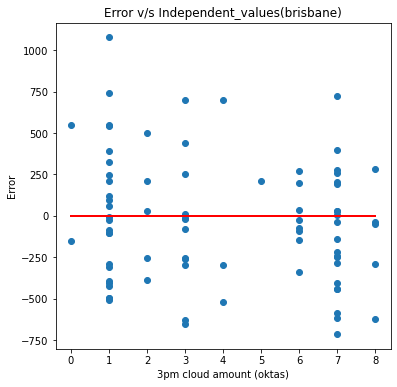

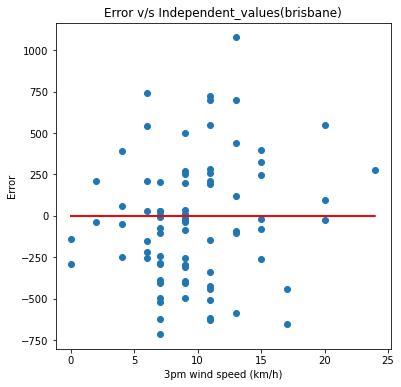

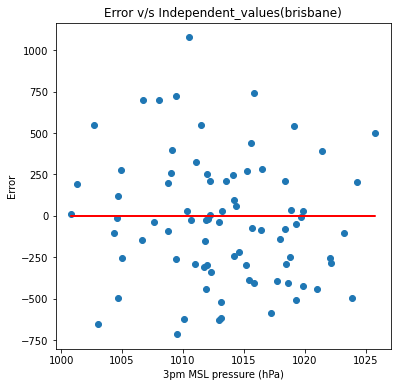

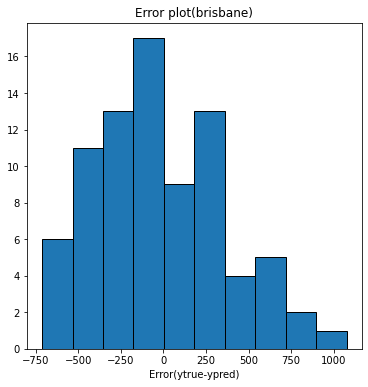

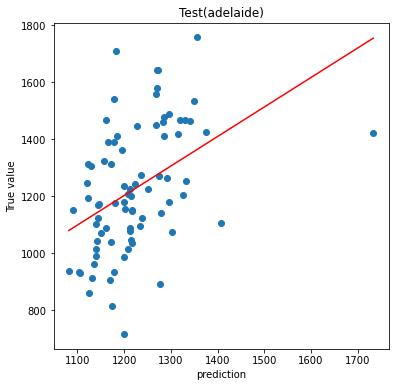

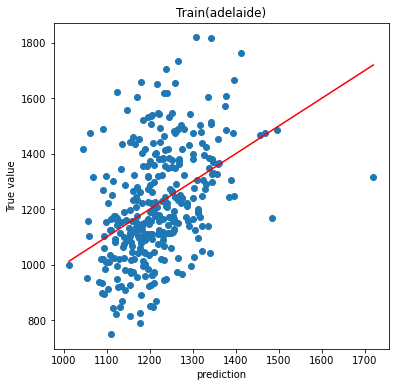

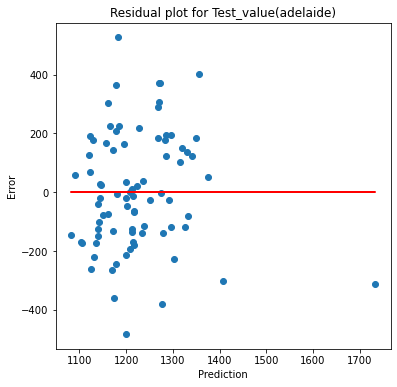

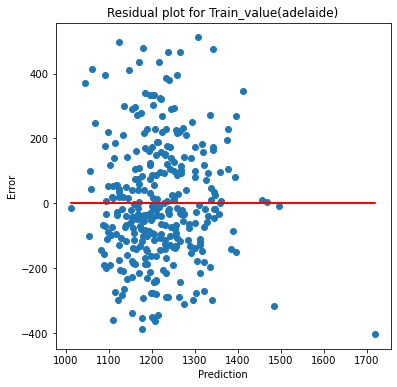

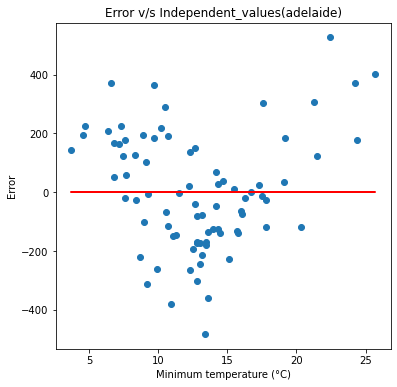

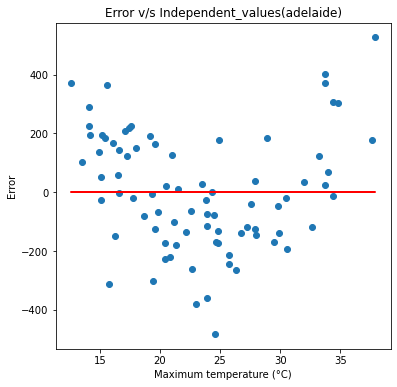

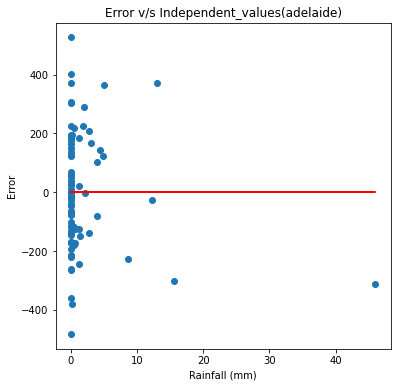

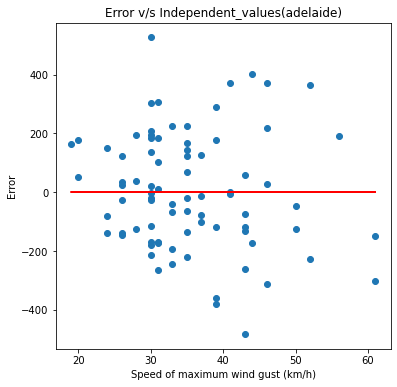

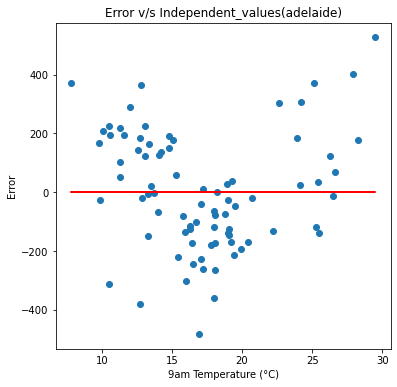

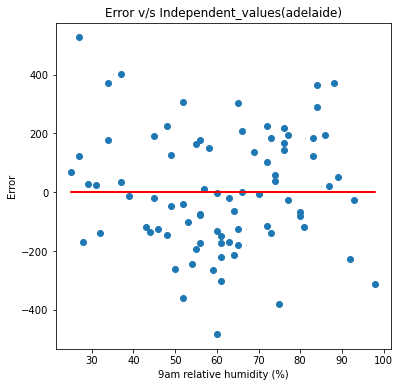

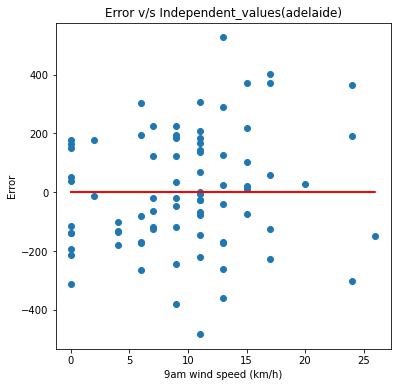

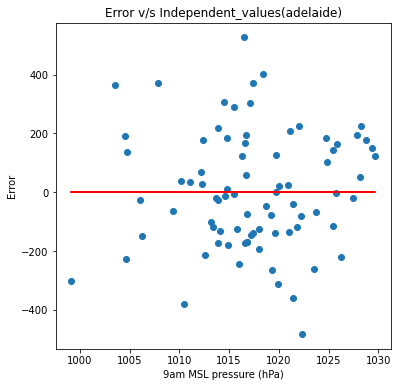

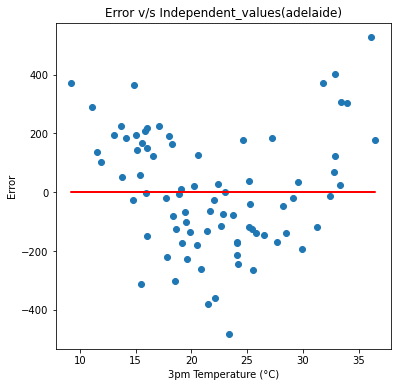

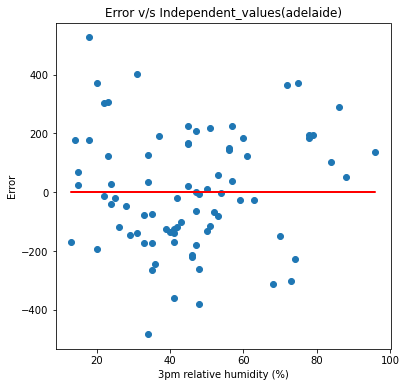

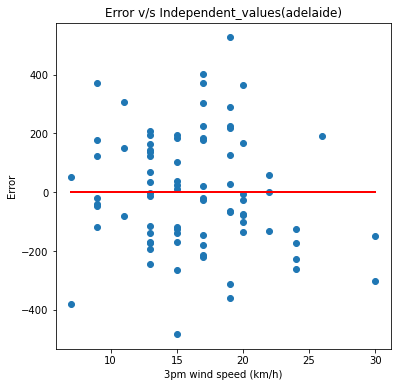

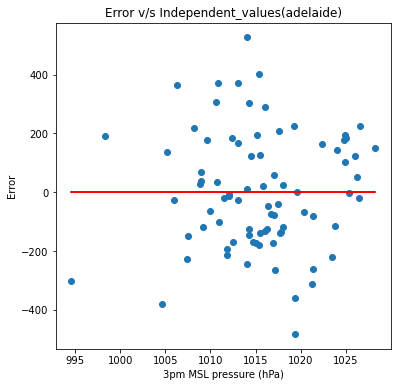

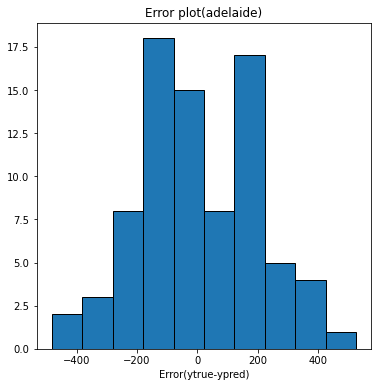

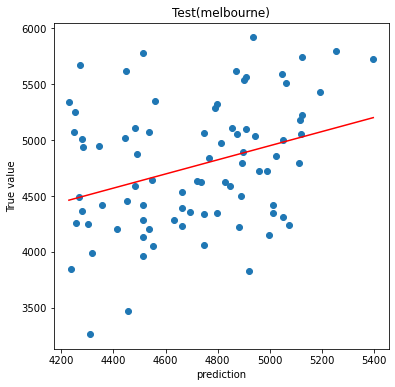

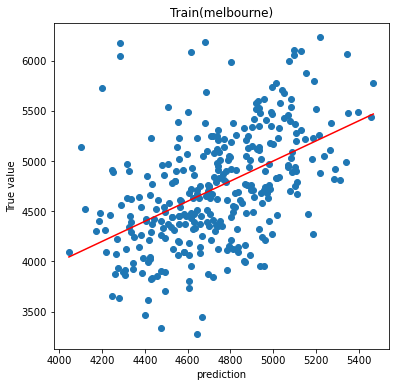

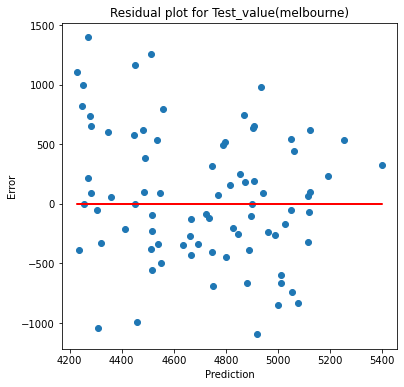

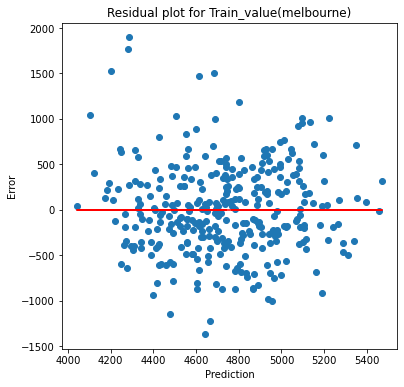

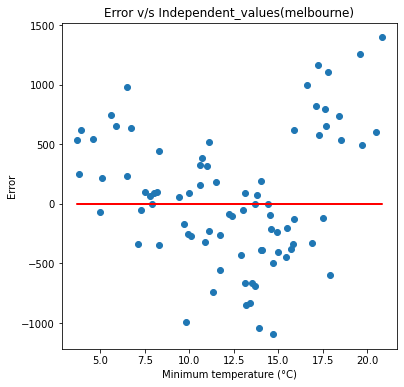

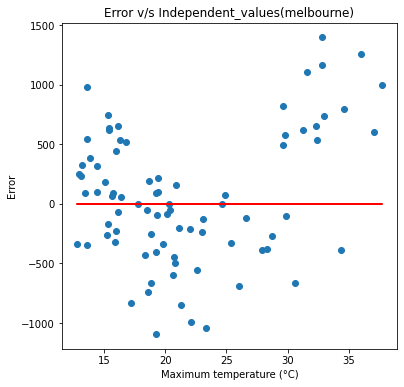

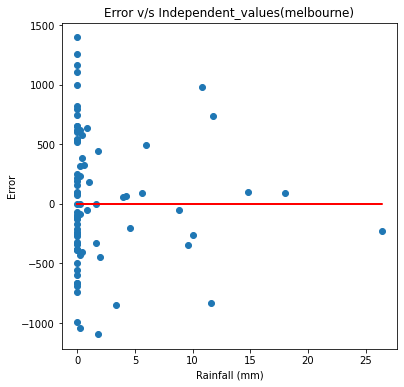

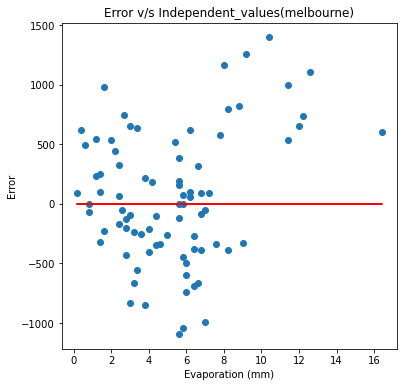

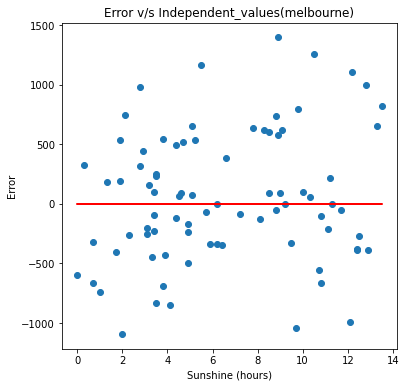

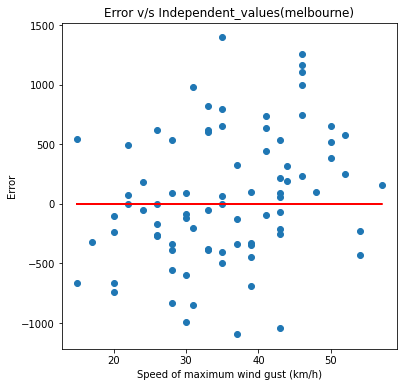

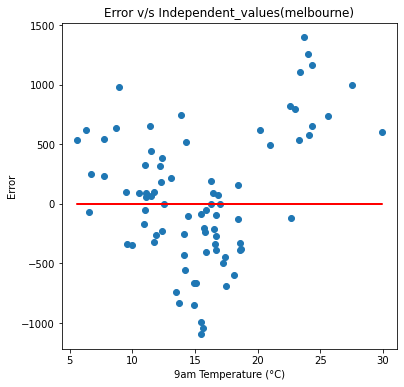

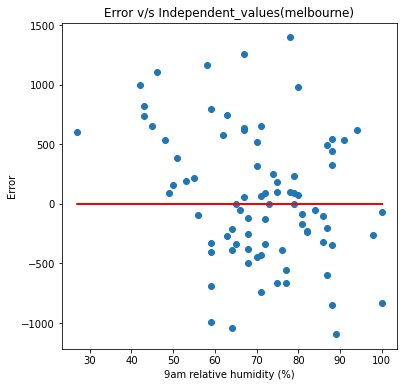

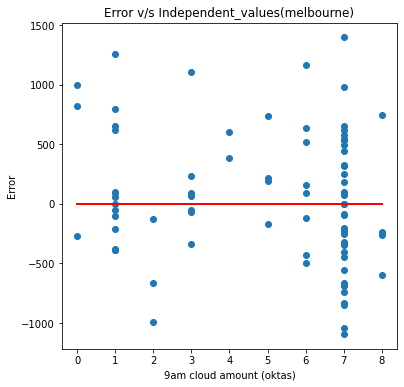

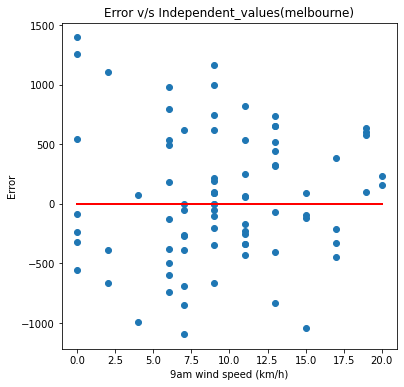

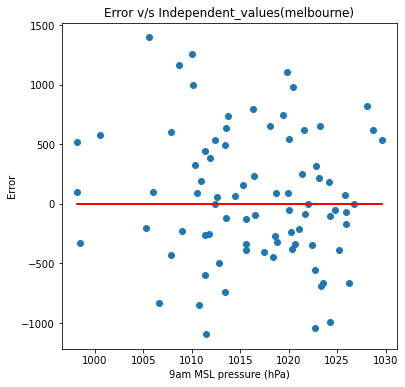

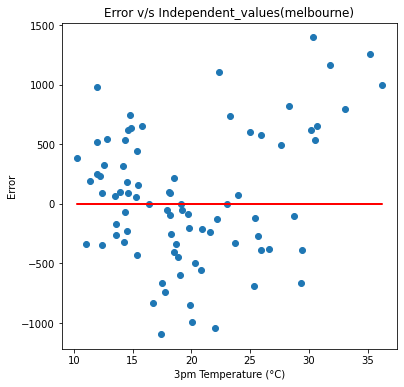

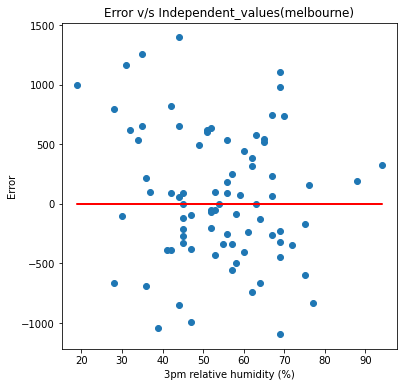

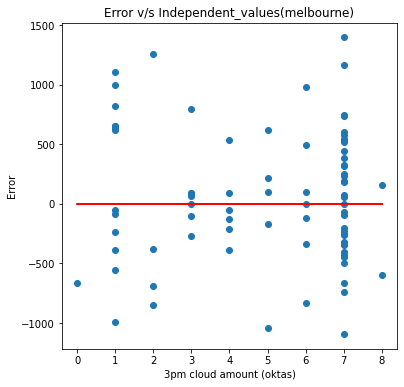

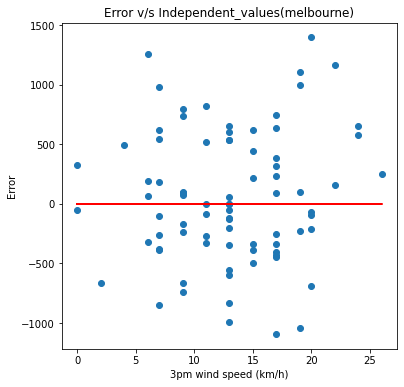

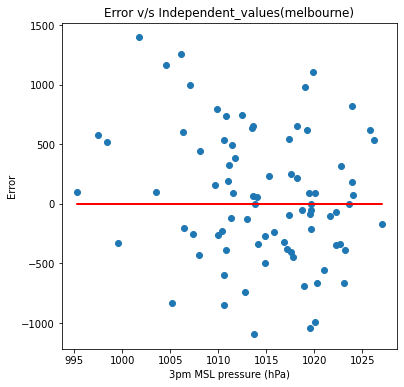

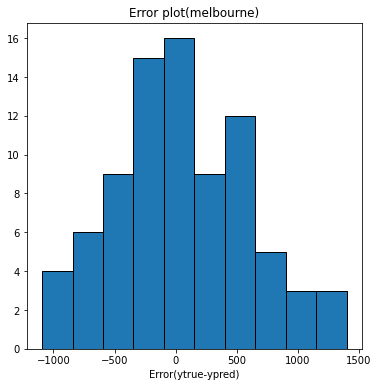

In [178]:
for city in cities:
    df = data[city].copy()
    print(f'\n\n############ {city} ############\n')
    df = df.drop(['Date','Time of maximum wind gust','PRICESURGE','PRICESURGEBOOL'],1)

    df = df.drop(['Direction of maximum wind gust ','9am wind direction','3pm wind direction'],1)
    
    df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 0) # splitting the data

    y_train = df_train.pop('TOTALDEMAND').values        
    X_train = df_train.values

    y_test = df_test.pop('TOTALDEMAND').values
    X_test = df_test.values

    cols = df_test.columns

    regressor, y_pred_test, y_pred_train = sktrain(X_train, y_train, X_test) # train the data
    
    skanalysis(y_pred_train, y_train, y_pred_test, y_test, X_test, cols, True) # Analysing

## With squared temperature



############ sydney ############
Index(['Minimum temperature (°C)', 'Maximum temperature (°C)',
       '9am Temperature (°C)', '3pm Temperature (°C)',
       'Minimum temperature (°C) squared', 'Maximum temperature (°C) squared',
       '9am Temperature (°C) squared', '3pm Temperature (°C) squared'],
      dtype='object')
[-387.71464227 -217.19819239 -329.74248702 -160.90404154   15.58225972
    4.1142045     6.48764927    3.61711612]
MSE_test:480.7911339473642/7561.01557441701
MSE_train:470.05618551563987/7545.900722038898
mse_test_rel:0.06358816870767198
mse_train_rel:0.06229291940493897
R2 score_test: 0.6363389152117711
R2 score_train: 0.6238748046279027
R2 score_test adj: 0.5959321280130789
R2 score_train adj: 0.6143224187136906


############ brisbane ############
Index(['Minimum temperature (°C)', 'Maximum temperature (°C)',
       '9am Temperature (°C)', '3pm Temperature (°C)',
       'Minimum temperature (°C) squared', 'Maximum temperature (°C) squared',
       '9am Temperatu

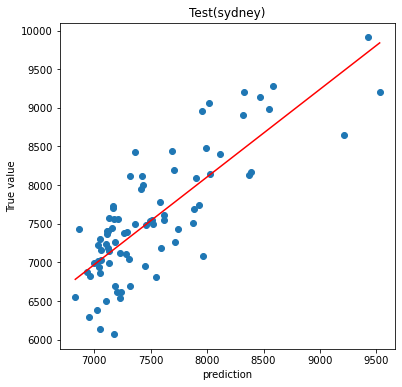

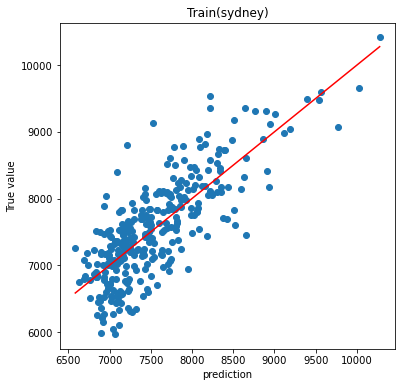

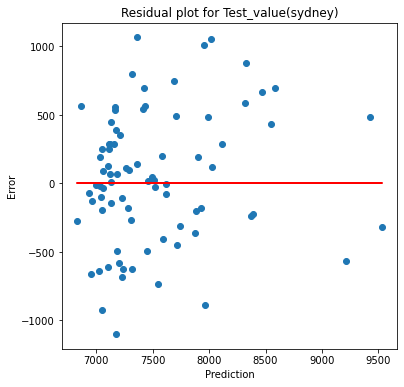

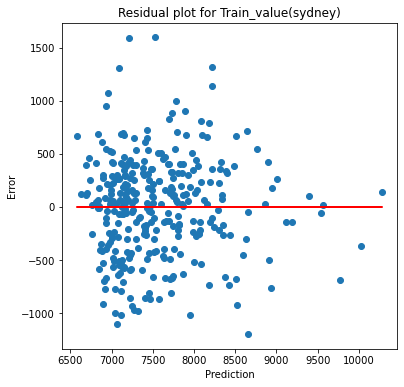

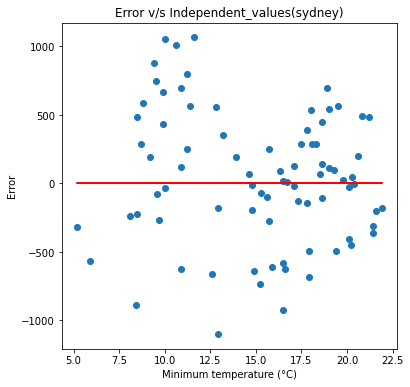

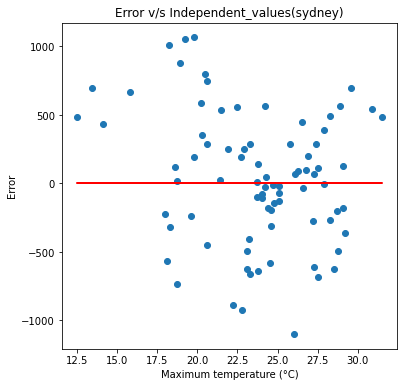

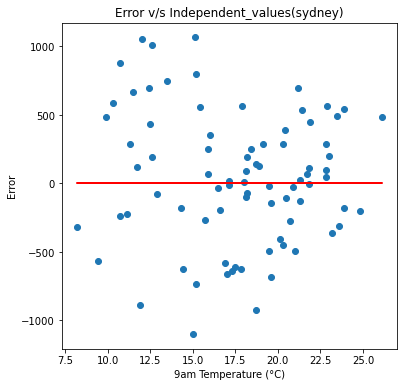

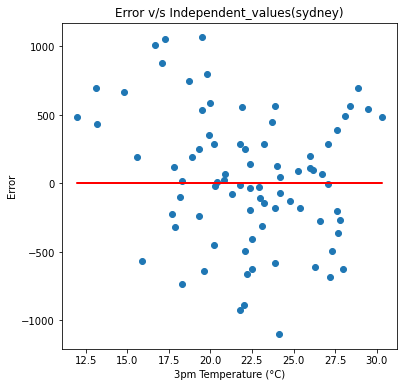

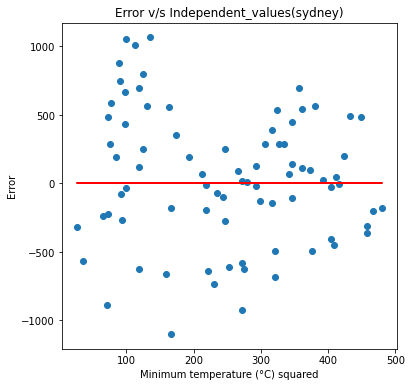

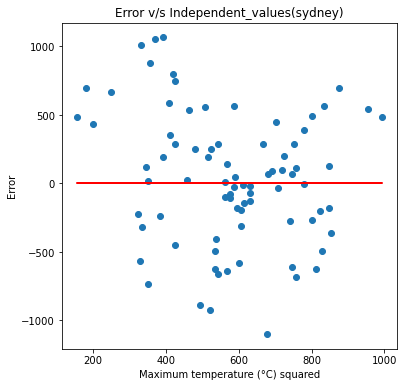

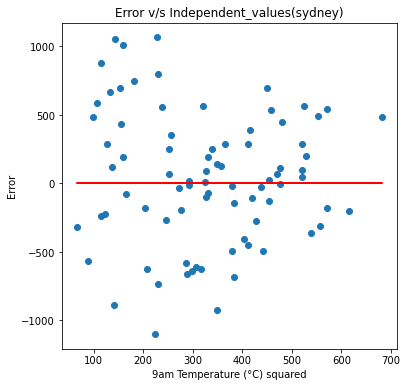

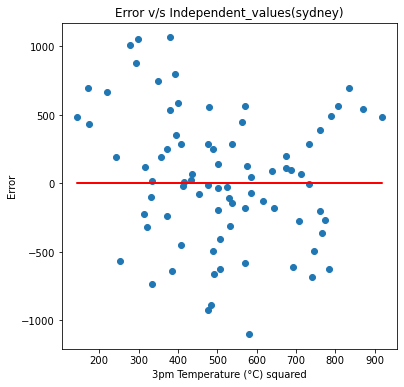

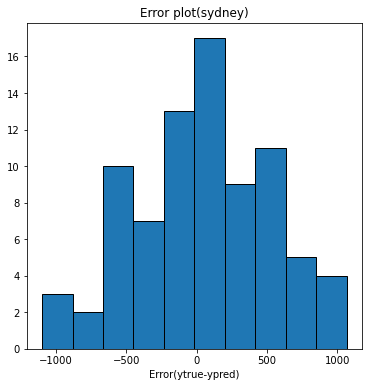

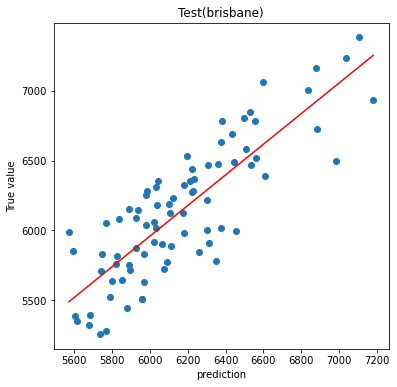

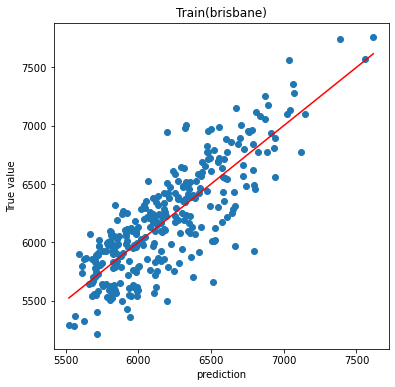

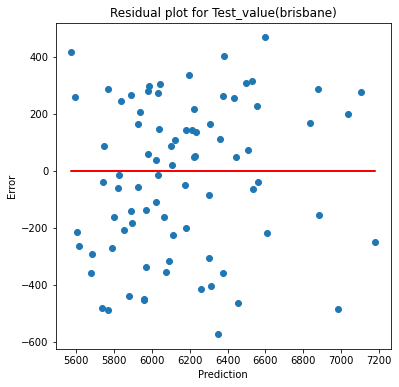

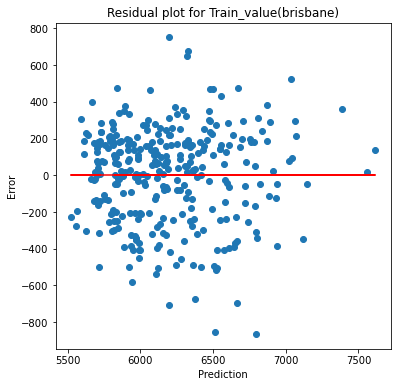

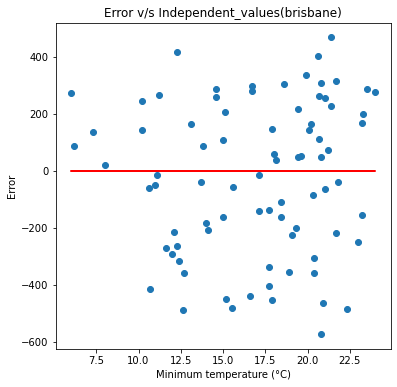

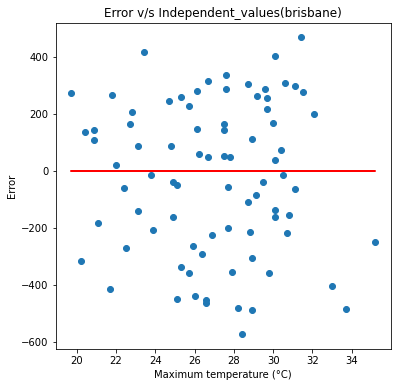

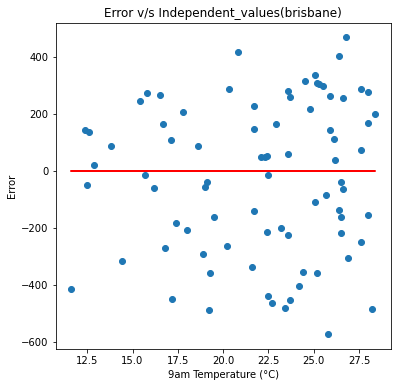

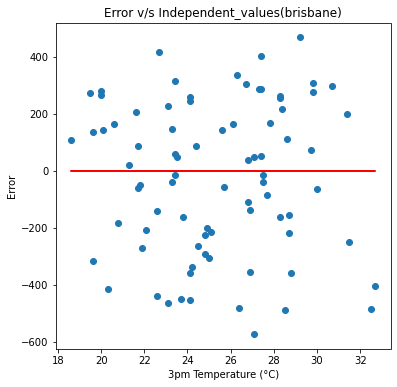

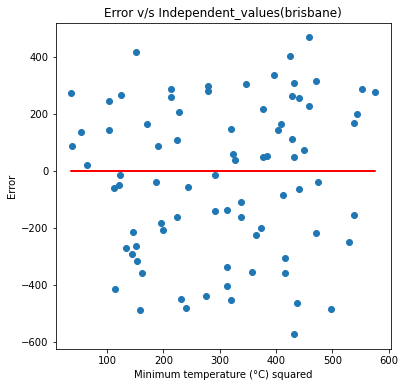

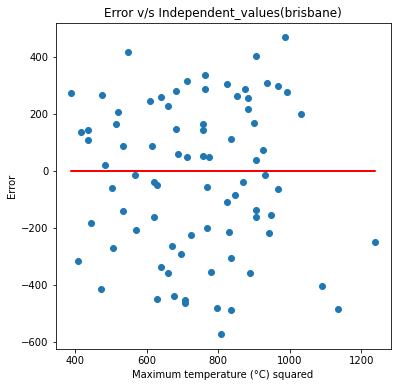

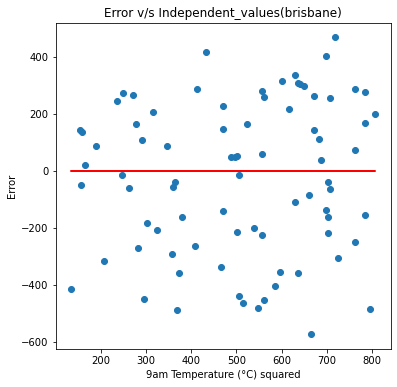

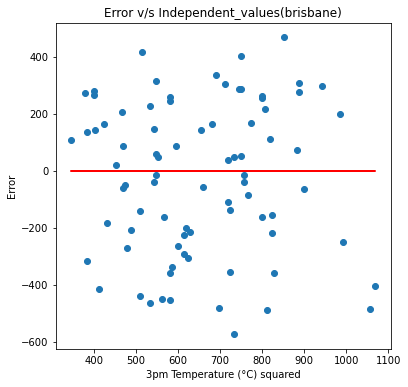

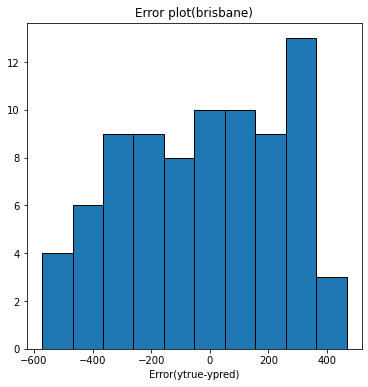

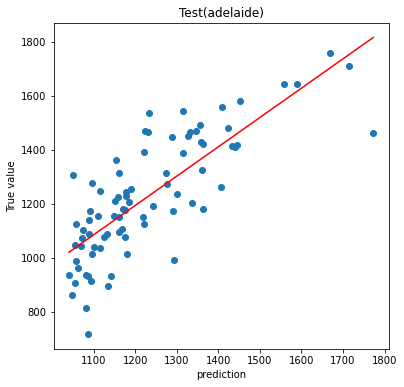

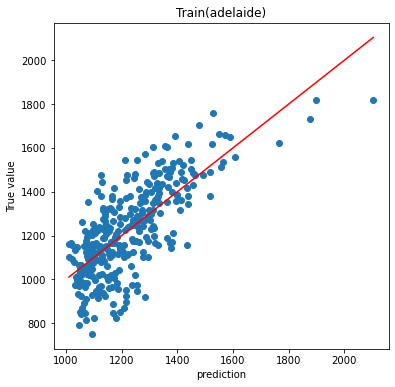

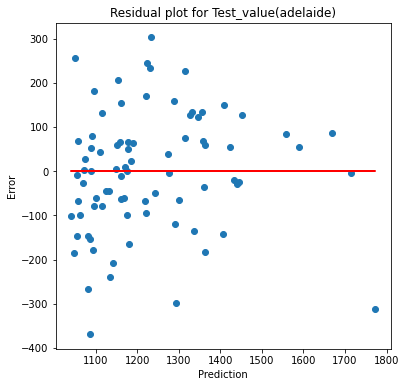

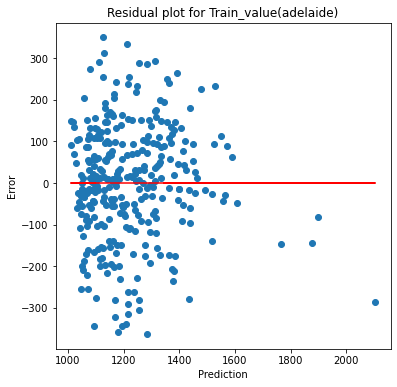

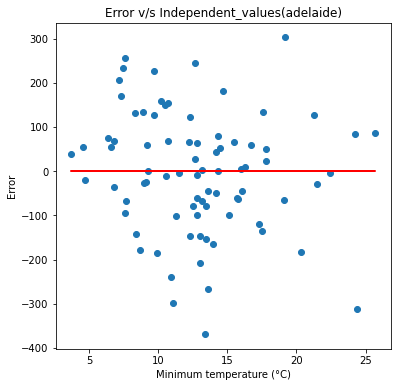

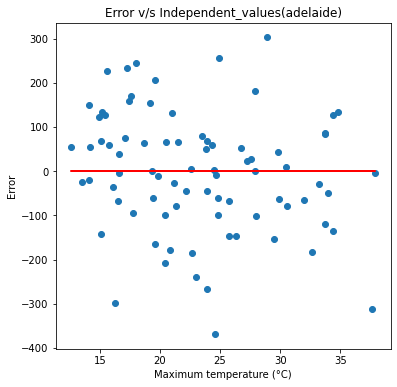

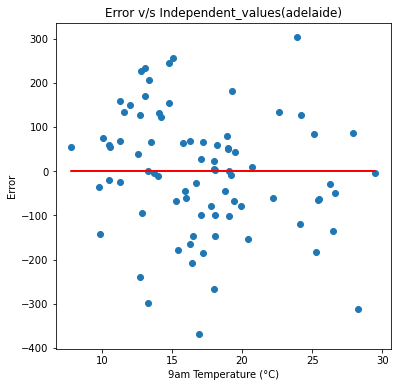

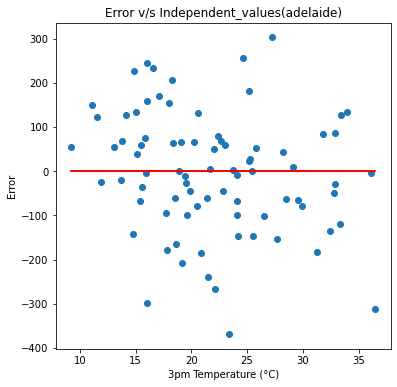

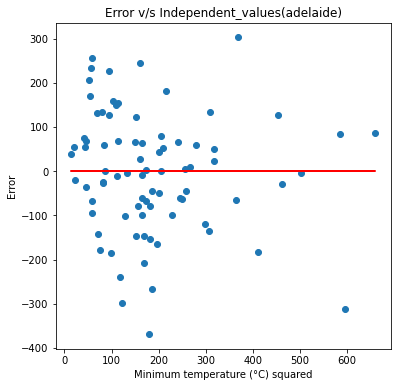

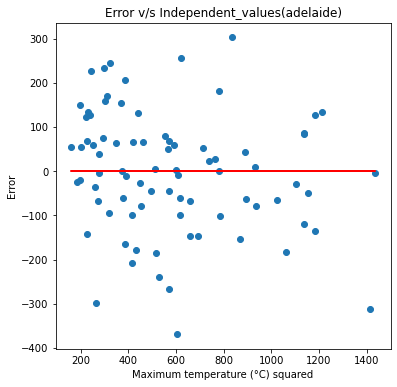

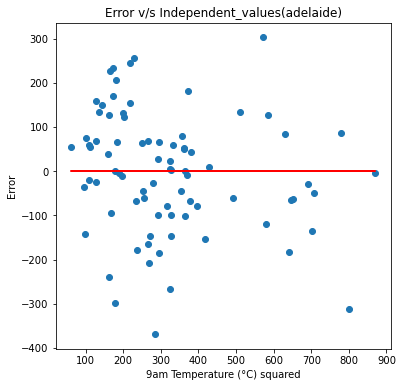

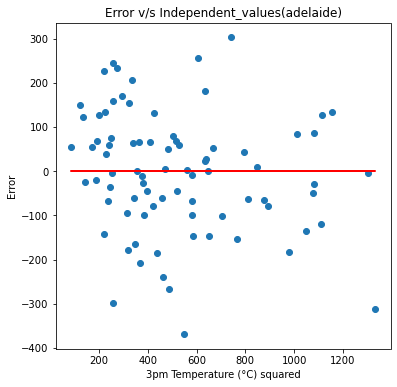

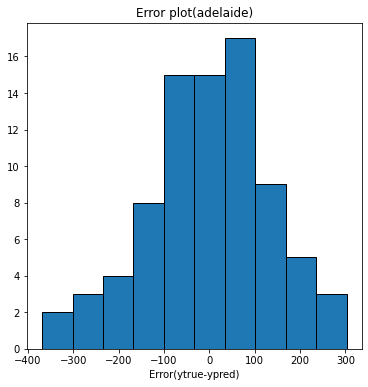

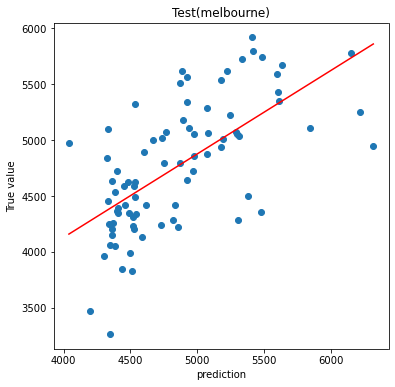

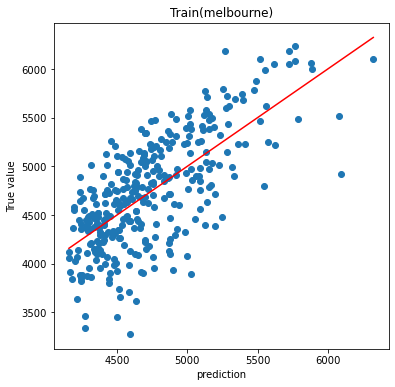

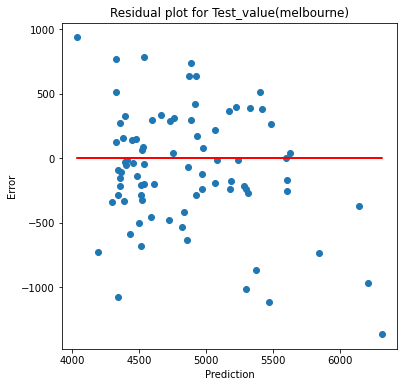

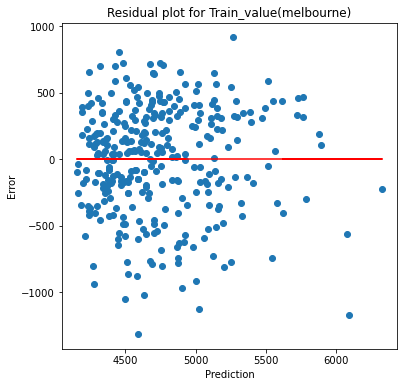

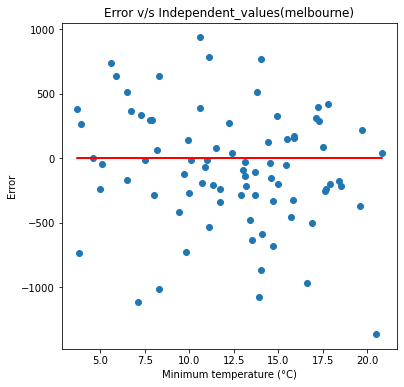

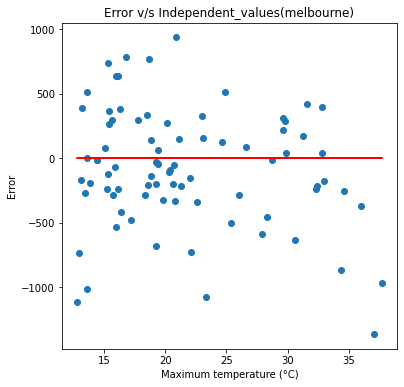

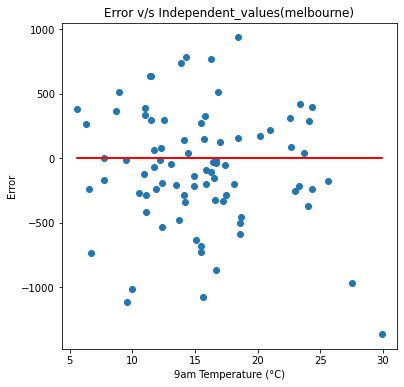

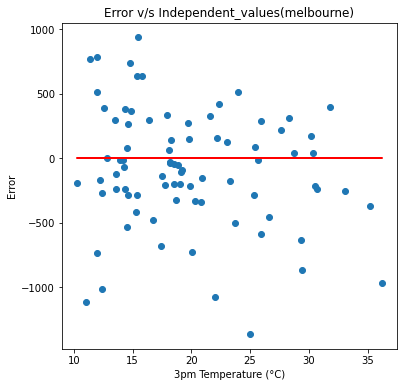

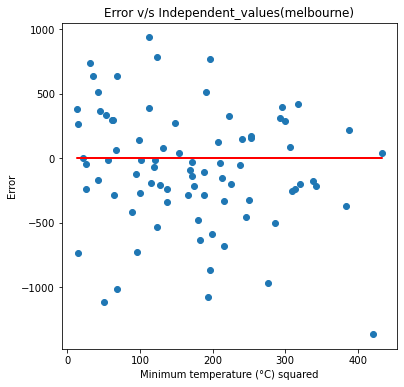

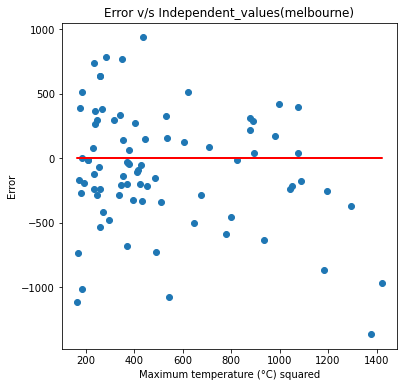

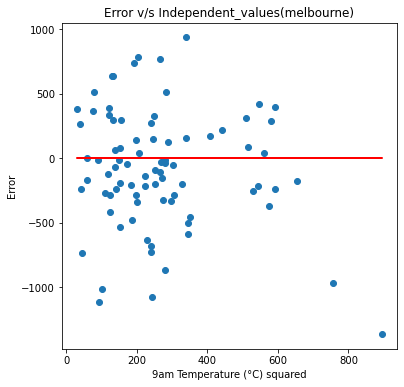

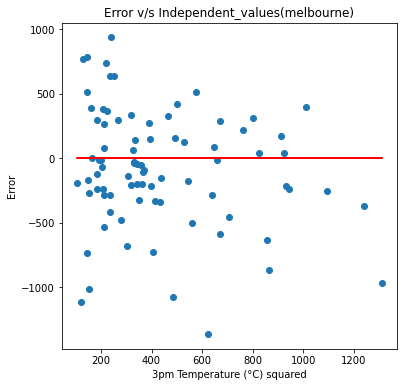

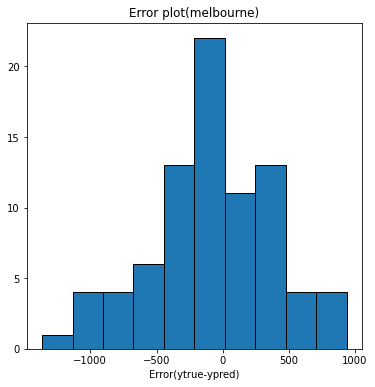

In [179]:
for city in cities:
    
    df = data[city].copy()
    print(f'\n\n############ {city} ############')
    df = df[['Minimum temperature (°C)','Maximum temperature (°C)','9am Temperature (°C)','3pm Temperature (°C)','TOTALDEMAND']]
    df['Minimum temperature (°C) squared'] =  df['Minimum temperature (°C)']**2   
    df['Maximum temperature (°C) squared'] =  df['Maximum temperature (°C)']**2
    df['9am Temperature (°C) squared'] =  df['9am Temperature (°C)']**2
    df['3pm Temperature (°C) squared'] =  df['3pm Temperature (°C)']**2

    
    df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 0)

    y_train = df_train.pop('TOTALDEMAND').values
    X_train = df_train.values

    y_test = df_test.pop('TOTALDEMAND').values
    X_test = df_test.values

    cols = df_test.columns

    regressor, y_pred_test, y_pred_train = sktrain(X_train, y_train, X_test)
    print(cols)
    print(regressor.coef_)
    
    skanalysis(y_pred_train, y_train, y_pred_test, y_test, X_test, cols, True)

## Only one temperature

### Minimum

In [180]:
for city in cities:
    
    df = data[city].copy()
    print(f'\n\n############ {city} ############')
    df = df[['Minimum temperature (°C)','TOTALDEMAND']]
    df['Minimum temperature (°C) squared'] =  df['Minimum temperature (°C)']**2   
 
    df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 0)

    y_train = df_train.pop('TOTALDEMAND').values
    X_train = df_train.values

    y_test = df_test.pop('TOTALDEMAND').values
    X_test = df_test.values

    cols = df_test.columns

    regressor, y_pred_test, y_pred_train = sktrain(X_train, y_train, X_test)
    print(cols)
    print(regressor.coef_)
    
    skanalysis(y_pred_train, y_train, y_pred_test, y_test, X_test, cols, False)



############ sydney ############
Index(['Minimum temperature (°C)', 'Minimum temperature (°C) squared'], dtype='object')
[-814.57170367   26.15249787]
MSE_test:611.4126006145028/7561.01557441701
MSE_train:558.9842389797212/7545.900722038898
mse_test_rel:0.08086381976030325
mse_train_rel:0.07407786817909315
R2 score_test: 0.41189794259355883
R2 score_train: 0.4680975289586313
R2 score_test adj: 0.3968184026600604
R2 score_train adj: 0.4647834948711461


############ brisbane ############
Index(['Minimum temperature (°C)', 'Minimum temperature (°C) squared'], dtype='object')
[-270.44036465   10.41929132]
MSE_test:280.7135766911507/6137.431941872428
MSE_train:293.02267989140057/6184.993636737219
mse_test_rel:0.045737953487678056
mse_train_rel:0.04737639148905889
R2 score_test: 0.6564346165623496
R2 score_train: 0.599335926814939
R2 score_test adj: 0.647625247756256
R2 score_train adj: 0.5968080777727619


############ adelaide ############
Index(['Minimum temperature (°C)', 'Minimum tem

### Maximum

In [181]:
for city in cities:
    
    df = data[city].copy()
    print(f'\n\n############ {city} ############')
    df = df[['Maximum temperature (°C)','TOTALDEMAND']] 
    df['Maximum temperature (°C) squared'] =  df['Maximum temperature (°C)']**2
 

    df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 0)

    y_train = df_train.pop('TOTALDEMAND').values
    X_train = df_train.values

    y_test = df_test.pop('TOTALDEMAND').values
    X_test = df_test.values

    cols = df_test.columns

    regressor, y_pred_test, y_pred_train = sktrain(X_train, y_train, X_test)
    print(cols)
    print(regressor.coef_)
    
    skanalysis(y_pred_train, y_train, y_pred_test, y_test, X_test, cols, False)



############ sydney ############
Index(['Maximum temperature (°C)', 'Maximum temperature (°C) squared'], dtype='object')
[-786.92578808   15.40230285]
MSE_test:548.941176497485/7561.01557441701
MSE_train:605.3578185843671/7545.900722038898
mse_test_rel:0.07260151379066707
mse_train_rel:0.0802234008746407
R2 score_test: 0.5259375610580341
R2 score_train: 0.3761830164721316
R2 score_test adj: 0.513782113905676
R2 score_train adj: 0.3722963062943879


############ brisbane ############
Index(['Maximum temperature (°C)', 'Maximum temperature (°C) squared'], dtype='object')
[-420.77433151    9.10803987]
MSE_test:415.19051740322107/6137.431941872428
MSE_train:382.02242017439085/6184.993636737219
mse_test_rel:0.06764889962699176
mse_train_rel:0.06176601668678835
R2 score_test: 0.24841619093232337
R2 score_train: 0.3189866382177391
R2 score_test adj: 0.2291448112126394
R2 score_train adj: 0.3146900239478194


############ adelaide ############
Index(['Maximum temperature (°C)', 'Maximum temp

### 9am temp

In [182]:
for city in cities:
    
    df = data[city].copy()
    print(f'\n\n############ {city} ############')
    df = df[['9am Temperature (°C)','TOTALDEMAND']]
    df['9am Temperature (°C) squared'] =  df['9am Temperature (°C)']**2

    
    df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 0)

    y_train = df_train.pop('TOTALDEMAND').values
    X_train = df_train.values

    y_test = df_test.pop('TOTALDEMAND').values
    X_test = df_test.values

    cols = df_test.columns

    regressor, y_pred_test, y_pred_train = sktrain(X_train, y_train, X_test)
    print(cols)
    print(regressor.coef_)
    
    skanalysis(y_pred_train, y_train, y_pred_test, y_test, X_test, cols, False)



############ sydney ############
Index(['9am Temperature (°C)', '9am Temperature (°C) squared'], dtype='object')
[-869.68670844   23.42019737]
MSE_test:518.884493537471/7561.01557441701
MSE_train:533.7159065325657/7545.900722038898
mse_test_rel:0.06862629608820499
mse_train_rel:0.070729251045375
R2 score_test: 0.5764298822593724
R2 score_train: 0.5150988933787444
R2 score_test adj: 0.5655691100096127
R2 score_train adj: 0.5120777026832848


############ brisbane ############
Index(['9am Temperature (°C)', '9am Temperature (°C) squared'], dtype='object')
[-341.60601741    9.31523302]
MSE_test:359.97506880682124/6137.431941872428
MSE_train:358.898546605947/6184.993636737219
mse_test_rel:0.05865239276233813
mse_train_rel:0.05802731056571909
R2 score_test: 0.4350273680788128
R2 score_train: 0.39893515311005734
R2 score_test adj: 0.42054089033724384
R2 score_train adj: 0.39514294587415866


############ adelaide ############
Index(['9am Temperature (°C)', '9am Temperature (°C) squared'], 

### 3pm temp

In [183]:
for city in cities:
    
    df = data[city].copy()
    print(f'\n\n############ {city} ############')
    df = df[['3pm Temperature (°C)','TOTALDEMAND']]
    
    df['3pm Temperature (°C) squared'] =  df['3pm Temperature (°C)']**2

    
    df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 0)

    y_train = df_train.pop('TOTALDEMAND').values
    X_train = df_train.values

    y_test = df_test.pop('TOTALDEMAND').values
    X_test = df_test.values

    cols = df_test.columns

    regressor, y_pred_test, y_pred_train = sktrain(X_train, y_train, X_test)
    print(cols)
    print(regressor.coef_)
    
    skanalysis(y_pred_train, y_train, y_pred_test, y_test, X_test, cols, False)



############ sydney ############
Index(['3pm Temperature (°C)', '3pm Temperature (°C) squared'], dtype='object')
[-670.84450062   13.86800052]
MSE_test:595.851704226025/7561.01557441701
MSE_train:631.9654178967434/7545.900722038898
mse_test_rel:0.07880577659992032
mse_train_rel:0.08374950071248574
R2 score_test: 0.4414522577412504
R2 score_train: 0.3201399689928691
R2 score_test adj: 0.4271305207602568
R2 score_train adj: 0.31590408094921096


############ brisbane ############
Index(['3pm Temperature (°C)', '3pm Temperature (°C) squared'], dtype='object')
[-282.39212262    6.69974576]
MSE_test:426.7597967128329/6137.431941872428
MSE_train:409.16908549731926/6184.993636737219
mse_test_rel:0.06953393548876334
mse_train_rel:0.0661551344316611
R2 score_test: 0.20594686841162557
R2 score_train: 0.21876164520814634
R2 score_test adj: 0.18558653170423134
R2 score_train adj: 0.21383269659747217


############ adelaide ############
Index(['3pm Temperature (°C)', '3pm Temperature (°C) squared

### Min and Max temp



############ sydney ############
Index(['Minimum temperature (°C)', 'Maximum temperature (°C)',
       'Minimum temperature (°C) squared', 'Maximum temperature (°C) squared'],
      dtype='object')
[-632.70033851 -502.21130684   21.28126816    9.58585054]
MSE_test:473.50992361890377/7561.01557441701
MSE_train:493.01093420314163/7545.900722038898
mse_test_rel:0.06262517501234133
mse_train_rel:0.06533493513414929
R2 score_test: 0.6472702428307635
R2 score_train: 0.5862423990575844
R2 score_test adj: 0.6287055187692248
R2 score_train adj: 0.5810542159736669


############ brisbane ############
Index(['Minimum temperature (°C)', 'Maximum temperature (°C)',
       'Minimum temperature (°C) squared', 'Maximum temperature (°C) squared'],
      dtype='object')
[-212.8032718  -382.62422647    8.84065646    7.10675536]
MSE_test:271.19582442349866/6137.431941872428
MSE_train:269.9720309229422/6184.993636737219
mse_test_rel:0.04418718235770144
mse_train_rel:0.043649524442414954
R2 score_test: 0.

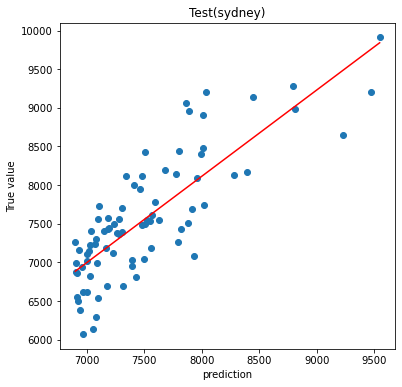

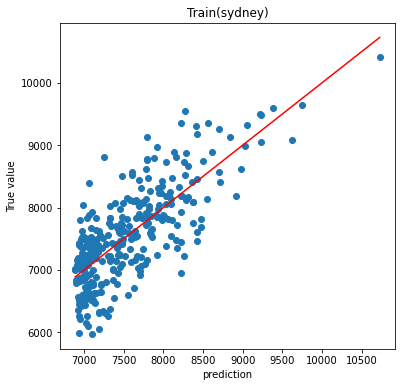

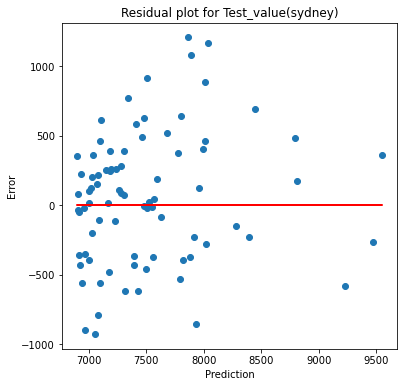

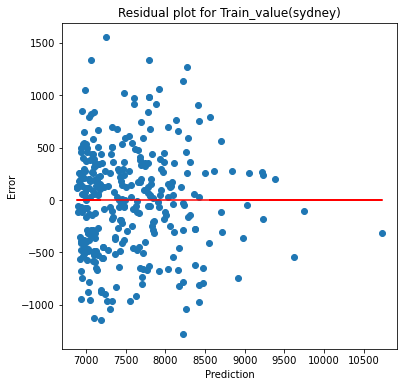

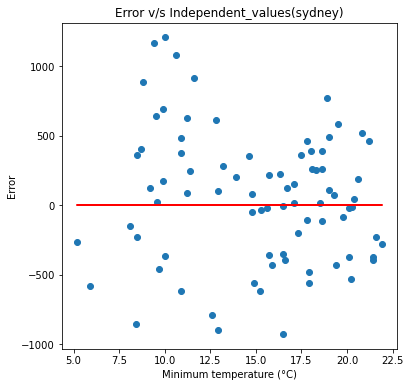

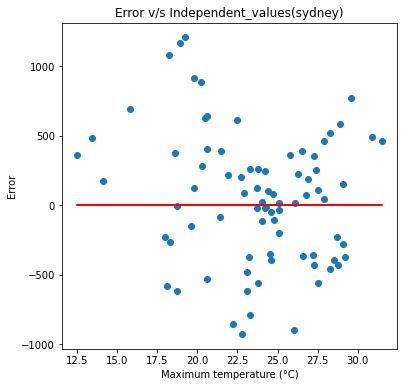

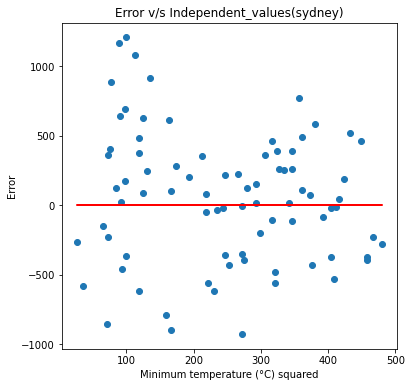

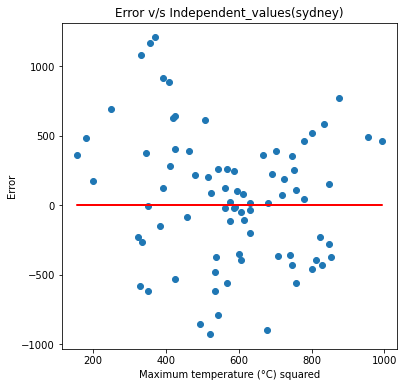

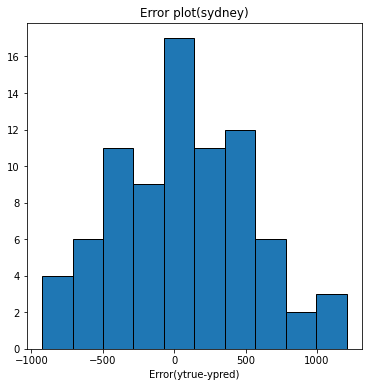

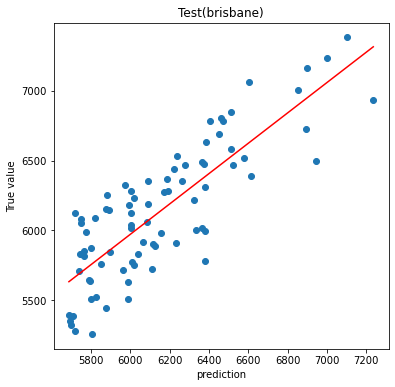

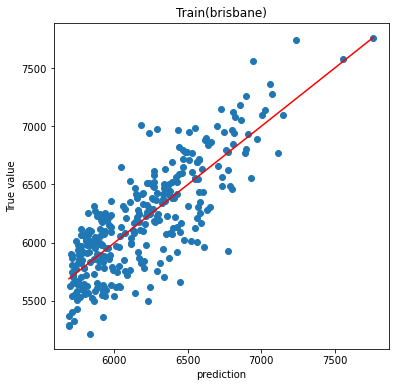

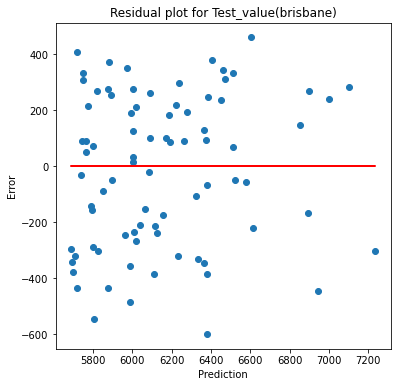

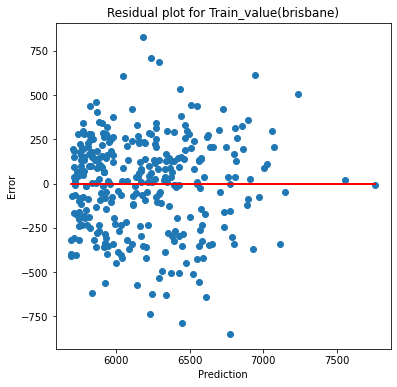

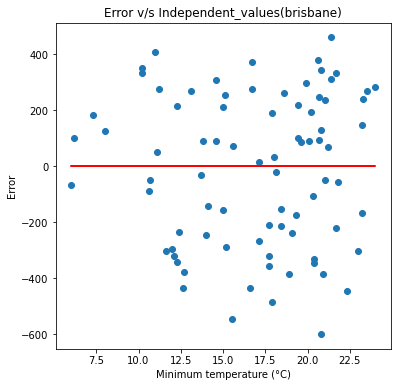

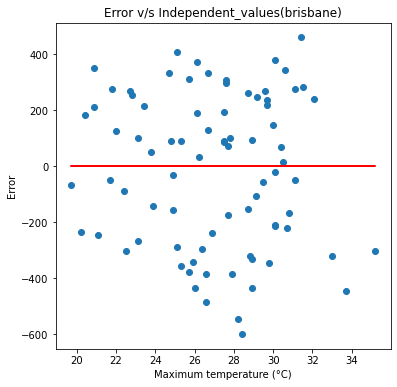

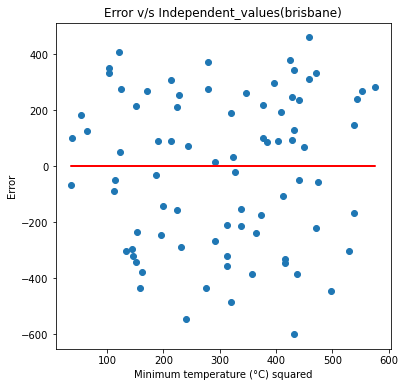

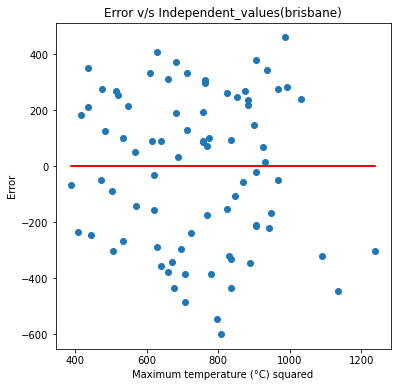

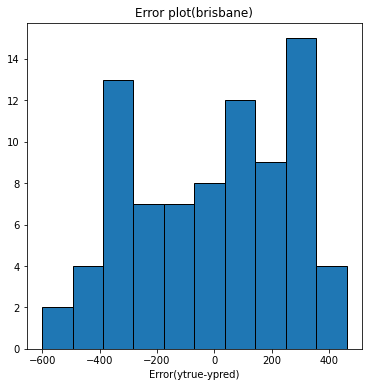

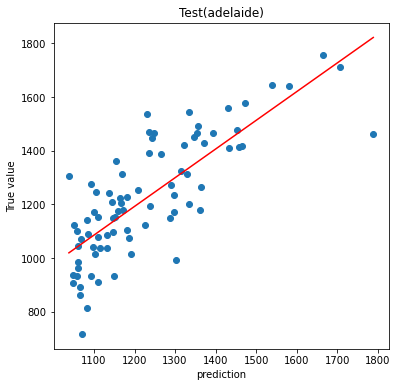

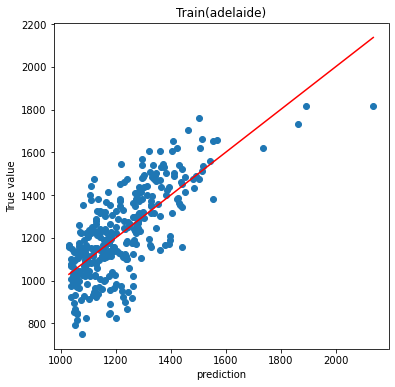

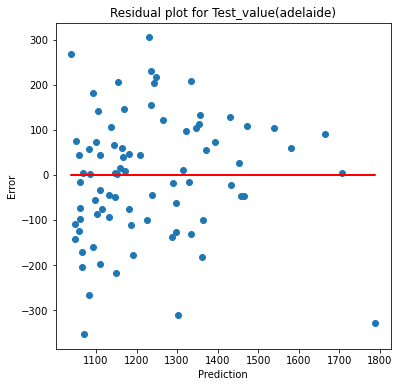

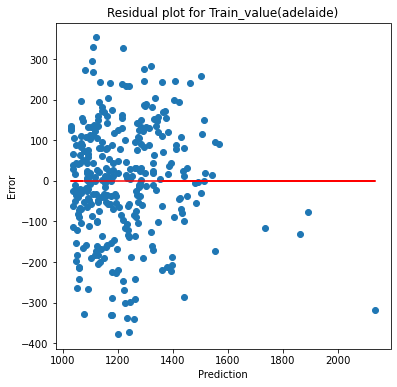

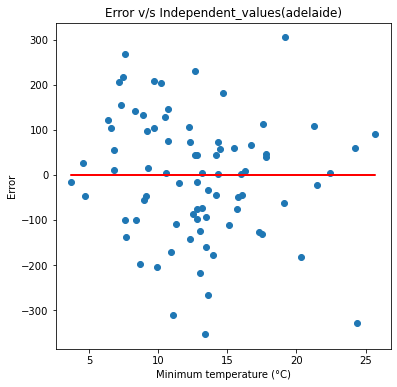

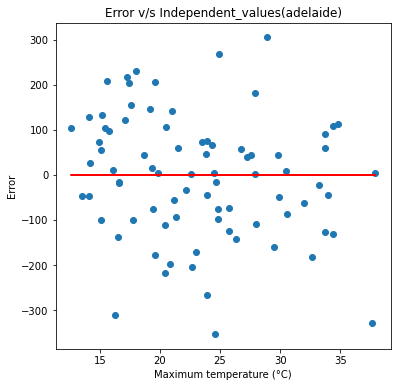

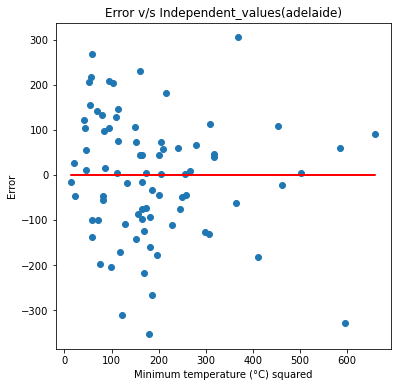

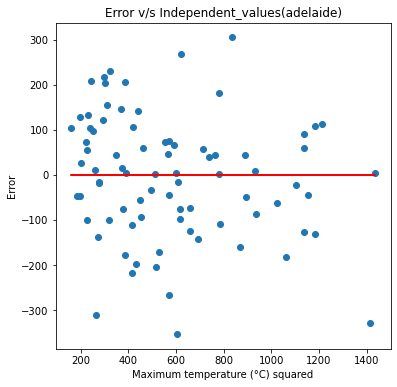

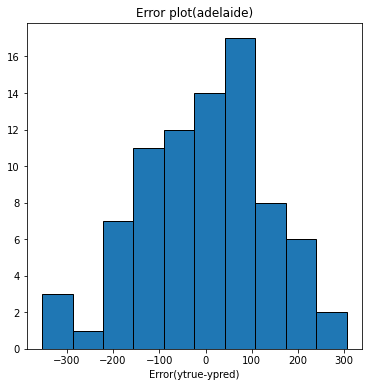

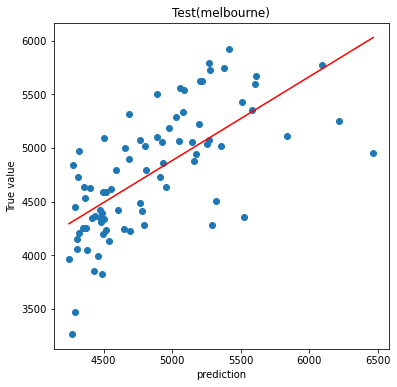

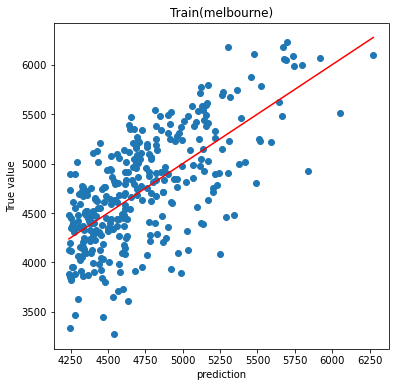

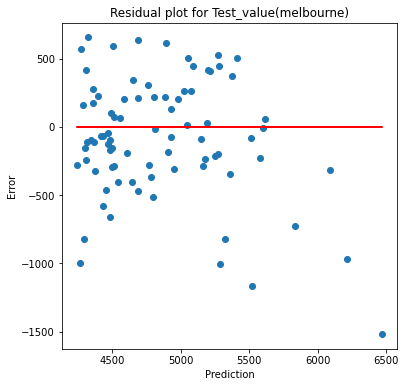

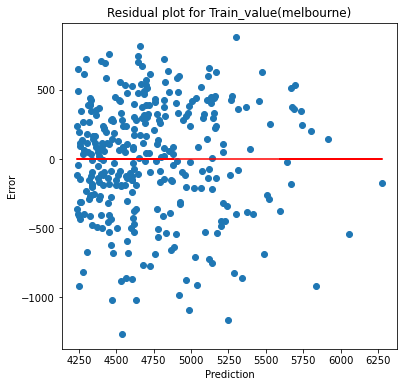

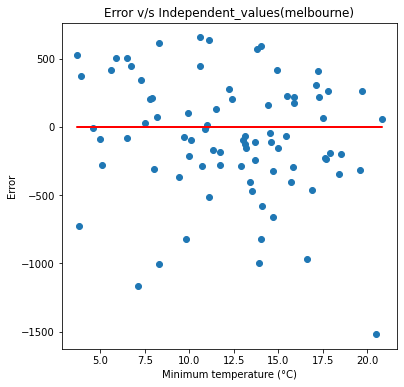

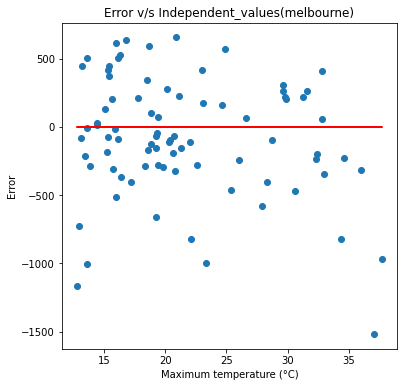

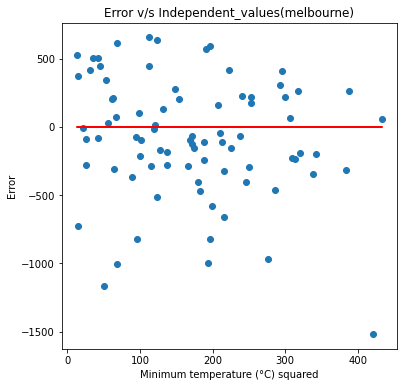

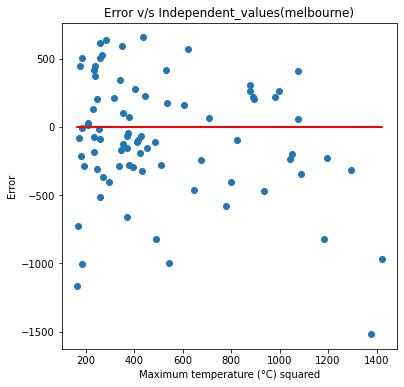

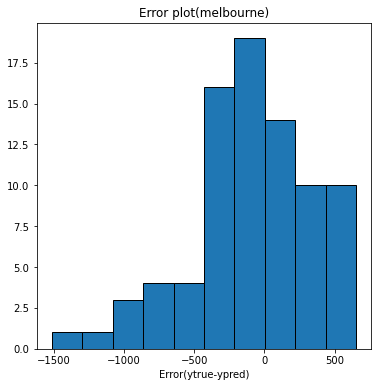

In [184]:
for city in cities:
    
    df = data[city].copy()
    print(f'\n\n############ {city} ############')
    df = df[['Minimum temperature (°C)','Maximum temperature (°C)','TOTALDEMAND']]
    df['Minimum temperature (°C) squared'] =  df['Minimum temperature (°C)']**2   
    df['Maximum temperature (°C) squared'] =  df['Maximum temperature (°C)']**2

    
    df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 0)

    y_train = df_train.pop('TOTALDEMAND').values
    X_train = df_train.values

    y_test = df_test.pop('TOTALDEMAND').values
    X_test = df_test.values

    cols = df_test.columns

    regressor, y_pred_test, y_pred_train = sktrain(X_train, y_train, X_test)
    print(cols)
    print(regressor.coef_)
    
    skanalysis(y_pred_train, y_train, y_pred_test, y_test, X_test, cols, True)